# Stock Trades by Members of the US House of Representatives

This project uses public data about the stock trades made by members of the US House of Representatives. This data is collected and maintained by Timothy Carambat as part of the [House Stock Watcher](https://housestockwatcher.com/) project. The project describes itself as follows:

> With recent and ongoing investigations of incumbent congressional members being investigated for potentially violating the STOCK act. This website compiles this publicly available information in a format that is easier to digest then the original PDF source.
>
> Members of Congress must report periodic reports of their asset transactions. This website is purely for an informative purpose and aid in transparency.
>
> This site does not manipluate or censor any of the information from the original source. All data is transcribed by our community of contributors, which you can join for free by going to our transcription tool. Our moderation team takes great care in ensuring the accuracy of the information.
>
> This site is built and maintained by Timothy Carambat and supported with our contributors.

Some interesting questions to consider for this data set include:

- Is there a difference in stock trading behavior between political parties? For example:
    - does one party trade more often?
    - does one party make larger trades?
    - do the two parties invest in different stocks or sectors? For instance, do Democrats invest in Tesla more than Republicans?
- What congresspeople have made the most trades?
- What companies are most traded by congresspeople?
- Is there evidence of insider trading? For example, Boeing stock dropped sharply in February 2020. Were there a suspiciously-high number of sales of Boeing before the drop?
- When are stocks bought and sold? Is there a day of the week that is most common? Or a month of the year?

### Getting the Data

The full data set of stock trade disclosures is available as a CSV or as JSON at https://housestockwatcher.com/api.

This data set does not, however, contain the political affiliation of the congresspeople. If you wish to investigate a question that relies on having this information, you'll need to find another dataset that contains it and perform a merge. *Hint*: Kaggle is a useful source of data sets.


### Cleaning and EDA

- Clean the data.
    - Certain fields have "missing" data that isn't labeled as missing. For example, there are fields with the value "--." Do some exploration to find those values and convert them to null values.
    - You may also want to clean up the date columns to enable time-series exploration.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.


### Assessment of Missingness

- Assess the missingness per the requirements in `project03.ipynb`

### Hypothesis Test / Permutation Test
Find a hypothesis test or permutation test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
The question that we decided to investigate is "Do congress people make stock trades with insider information?" This question is rather vague, and a little bloated, so we can eventually cut it down to a more specific question, or set of questions, using a person's trading habits, their party leaning, and the date of the transactions themselves. This is where the dataset we chose comes in. The housestockwatcher project's dataset has every reported trade made by a House member listed as an observation with features of "representative" (name), "amount" (amount traded), "transaction_date", "ticker", "type" (purchase/sale etc.) These features will allow us to target specific aspects of insider trading that exist. For example, were there higher volumes of trading prior to and on days where a political decision had significant market implications? Which House members traded the most, and which House members traded the most on those days specifically? Did all members of congress collude to take advantage of insider information? Unfortunately our dataset does not have party-leaning as a feature, or a numerical value column, so we'll have to add those in ourselves, but when we do, we can also ask questions of our data like did members of specific parties take advantage of insider information? Which representatives made the most from trading? Ultimately while a lot of cleaning and feature manipulation is required, our data-set should give us the right tools to answer the over-arching question about insider trading in the House of Representatives.  

### Cleaning and EDA
This dataset was generated through two layers of entropy and abstraction: First, every member of the House was ordered by the House itself to fill out a form that detailed specific trades they made over a particular period of time. This was the first layer of abstraction. After filling out this form, the House uploaded it to their records as a PDF. The housestockwatcher project then had either a human or an inaccurate PCR look at this form and fill out an observation in their data-set for each trade listed on the form. This was the second layer of abstraction. This clerical process led to many fake missing values in the data in the form of "--", 5 inaccurate dates, 4 missing asset descriptions, and many, many inconsistently spelled representative names and asset descriptions. 

The first step of our cleaning was to replace all the fake missing values with real missing values with pd.replace. The next step was to hand fill the inaccurate dates by visiting the disclosure PDFs linked in the dataset and found on the House website, using pd.at, and converted the dates to real pd.Timestamps using pd.to_datetime. We again hand-filled the 4 trivial missing asset descriptions with pd.at. 

After this we decided to merge in a dataframe with the political affiliation of each representative. Unfortunately we could not find a clean, exhaustive, and cohesive csv on the internet with all of our representatives in this dataset listed. So we webscraped the official house website, which allows webscraping: https://www.congress.gov/robots.txt. Unfortunately this dataset did not have state abbreviations so we webscraped another website in order to create district codes for each representative (https://abbreviations.yourdictionary.com/robots.txt). After this we created a unique identifier column for our original dataset and our new dataset (concatenating the last name to the district code) which allowed us to merge without missing any former house members who might be in our original data but may not be the only representative for their district in the webscraped data.

Post-merge, we had a new clean column of names with no inconsistencies, and a new clean of party affiliations with no inconsistencies. This means that our cleaning and merging was robust enough to allow us to analyze parties with no repercussion. This was not the case for the value of each transaction. In order to create a numerical column that could be analyzed for our monetary value of each transaction ('amount') we were forced to take the minimum of every categorical range provided. This was because several transactions were missing upper bounds. Unfortunately since we didn't have the exact value of each transaction made by a congress person, this column had way too many inconsistencies to allow any form of valid, well-founded analysis. Furthermore by examining particular congress reports there was no consistency in whether or not a transaction amount was reported as an exact dollar value or a categorical range. Another weakness of the data generating process. 

The last bit of cleaning done was to attempt to normalize the asset descriptions. Due to the sheer randomness of inconsistency, there was no clear way to canonicalize the asset names, so simple string cleaning was performed. 

Our EDA was conducted primarily with the intention of informing our conjecture that insider trading does take place inside of the House. To do so we generated bar plots to determine how often members of congress traded, and which members of congress traded the most often. Similarly we attempted to use our monetary value column (min_value) to determine how much members of congress staked on trades. Finally we graphed the bivariate relationship between frequency of trades over time, both buying and selling as well as all trades, by party. This allowed us to determine spikes of trading volume on three dates in particular, and identify the individuals behind these spikes for further investigation. 

### Assessment of Missingness
Our cleaned dataset had only two columns with missingness to be evaluated. Specifically, owner and ticker, which describe the account type and stock market abbreviation for the asset respectively.

Ticker, could be NMAR, as we hypothesize that the generated ticker is reliant on its existence in the NASDAQ. However, given that asset description has no missing values, we can say that ticker is also likely MAR on the asset description. Given the limiations of our ability to clean the asset descriptions, we cannot establish if this would be missing by design due to inconsistencies in asset reporting generated by the handwriting and other forms of input to this column. 

Owner, we hypothesize to be MCAR with the minimum value of the trade. After sifting through multiple Congress asset reports, we failed to find any obvious correlations between the account type(denoted by owner) and the amount of transaction. However, we hypothesize it to be MAR with the represenative's name given that the type of account owned should be tied to who the representative selects to manage their account. 

To test this, we ran permutation tests by permuting the missingness of the ticker and owner columns and seeing how often we got a total variation distance as the observed. This was done with a significance level of 0.01 or 1%, considering the size of our dataset and the gravity of assessing so-called "insider-trading".
 
$H_0$: The distribution of our missing and non-missing data come from the same distribution. In other words, the missingness is MCAR. 
 
 $H_A$: The distribution of our missing and non-missing data does not come from the same distribution. In other words, the missingness is MAR. 
 
For owner we determined that the missingness of owner had no relationship with the transformed amount column (min_value, which denotes the minimum dollar value of the trade) with a p-value of 0.018. We determined the missingness of owner was MAR based on the representative with a p-value of 0. 

For ticker we determined that it was missing at random based on asset_description, again with a p-value of 0. Ultimately since our missingness is focused in columns that we do not use in our analysis, we shouldn't suffer too much or at all from missingness. Thus our ability to answer questions is unaffected by missingness.

### Hypothesis Test
For our hypothesis test we chose three potential hypotheses. The first was do the parties have different fiancial habits, as described by their trading volume? This was because differences in trading volume by party could demonstrate collusive insider trading (if every member of either party followed the same non-uniform distribution, that would be cause for concern). 

The second and third were, given the potential opportunity for inside trading on March 18th, 2020 did Greg Gianforte and Gilbert Ray Cisneros Jr. trade in unusually high volumes when compared to their own average trading across the time period within the dataset? If their trading volume on March 18th, 2020 is unusual for their trading patterns, then there is likely a strong possibility that they had some reason to trade in such high volumes on the day. 

Similarly, our last hypothesis was did Ro Khanna take advantage of information and trade in unusually high volumes on February 11, 2021 when compared to his own average trading across the time period within the dataset? Again, if his trading volume was unusual on the day of, there is a strong chance something, insider information or otherwise, motivated that behaviour.

We tested our first hypothesis with an $\alpha$ of 0.01. Our test statistic was the Total Variation Distance between the distribution of frequency for Dems and the distribution of frequency for Repubs. Our hypotheses were as follows:

$H_0$: The distribution of Republican trading volumes and the distribution of Democratic trading volumes are drawn from the same distribution. 

$H_A$: The distribution of Republican trading volumes and the distribution of Democratic trading volumes are not drawn from the same distribution.

We got a p-value of 0.568. This led to a failure to reject the null hypothesis, and thus a lack of proof of systematic and collusive insider trading from either party. This also demonstrated that trading patterns are individualistic and at least not determined by political affiliation. 

We tested the first part of our second hypothesis with an $\alpha$ of 0.01. Our test statistic was the volume of trading on March 20th, 2020 in comparison to every other volume of trading under an empirical distribution. Our hypotheses were as follows:

$H_0$: The number of trades Gregory Gianforte made on March 18, 2020 was drawn from the same distribution as the number trades he made on every other day. 

$H_A$: The number of trades Gregory Gianforte made on March 18, 2020 was drawn from a distribution with greater values than the number of trades he made on every other day. 

We got a p-value of 0.01. This led to a failure to reject the null hypothesis, and thus a lack of conclusive proof that Rep. Gianforte was trading outside of typical patterns. Notably this p-value was at our significance level.

We tested the second part of our second hypothesis with an $\alpha$ of 0.01. Our test statistic was the volume of trading on March 20th, 2020 in comparison to every other volume of trading under an empirical distribution. Our hypotheses were as follows:

$H_0$: The number of trades Gibert Cisneros made on March 18, 2020 was drawn from the same distribution as the number trades he made on every other day. 

$H_A$: The number of trades Gilbert Cisneros made on March 18, 2020 was drawn from a distribution with greater values than the number of trades he made on every other day. 

We got a p-value of 0.012. This led to a failure to reject the null hypothesis, and thus a lack of conclusive proof that Rep. Cisneros was trading outside of typical patterns. 

We tested our third hypothesis with an $\alpha$ of 0.01. Our test statistic was the volume of trading on February 11, 2021 in comparison to every other volume of trading under an empirical distribution. Our hypotheses were as follows:

$H_0$: The number of trades Ro Khanna made on February 11, 2021 was drawn from the same distribution as the number trades he made on every other day. 

$H_A$: The number of trades Ro Khanna made on February 11, 2021 was drawn from a distribution with greater values than the number of trades he made on every other day. 

We got a p-value of 0.023. This led to a failure to reject the null hypothesis, and thus a lack of conclusive proof that Rep. Cisneros was trading outside of typical patterns. 

A large limitation with all three of the individualized trading pattern hypotheses was that our sample size for all three was very low. Thus these are more of a proof of concept than an actual statistical test with any real significance. Further analysis should be done to determine whether these trading patterns are truly unusual. 

# Code

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

import os
import bs4
import requests

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
import scrape_congress
import hypoth_testing

### Cleaning and EDA

In [3]:
fp = os.path.join('data/', 'all_transactions.csv')
all_transactions = pd.read_csv(fp)
all_transactions.isna().sum()

disclosure_year              0
disclosure_date              0
transaction_date             0
owner                     4529
ticker                       0
asset_description            4
type                         0
amount                       0
representative               0
district                     0
ptr_link                     0
cap_gains_over_200_usd       0
dtype: int64

So let us begin by finding all potential fake missingness and turning it into real missingness. It appears, after some rigorous analysis (looking at each series potential values), that fake missingness exists in the 'owner' and 'ticker' columns. We will now replace those values with NaNs. In summary:

Missingness in data:
- Owner column has fake missing ('--') and real missing
- Ticker column has fake missing ('--')
- Asset description column has real missing but only 4 so we can hand clean this

In [4]:
all_transactions.iloc[732] #Replace NaN in a_d with Ball Corporation
all_transactions.iloc[3262] #Replace NaN in a_d with CELO
all_transactions.iloc[10537] #Replace NaN in a_d with URGO
all_transactions.iloc[10538] #Replace NaN in a_d with URGO

disclosure_year                                                        2021
disclosure_date                                                  03/18/2021
transaction_date                                                 2021-02-18
owner                                                                   NaN
ticker                                                                 URGO
asset_description                                                       NaN
type                                                               purchase
amount                                                     $1,001 - $15,000
representative                                              Hon. Brian Mast
district                                                               FL18
ptr_link                  https://disclosures-clerk.house.gov/public_dis...
cap_gains_over_200_usd                                                False
Name: 10538, dtype: object

In [5]:
all_transactions.at[732, 'asset_description'] = 'Ball Corporation'
all_transactions.at[3262, 'asset_description'] = 'CELO'
all_transactions.at[10537, 'asset_description'] = 'URGO'
all_transactions.at[10538, 'asset_description'] = 'URGO'

In the following cell we sorted the transaction date values to find the smallest values from a string perspective, and discovered several anomalies. For these anomalies our intention is to hand clean the data and make sure that the date listed matches the date reported in the PDF sent in to Congress. 

In [6]:
all_transactions['transaction_date'].sort_values().head()

2069    0009-06-09
9381    0021-06-22
3496    0021-08-02
9382    0201-06-22
8662    2012-06-19
Name: transaction_date, dtype: object

In [7]:
all_transactions.at[8662, 'transaction_date'] = '2020-06-19'
all_transactions.at[2069, 'transaction_date'] = '2021-06-09'
all_transactions.at[9381, 'transaction_date'] = '2021-06-22'
all_transactions.at[3496, 'transaction_date'] = '2021-08-02'
all_transactions.at[9382, 'transaction_date'] = '2021-06-22'

In [8]:
all_transactions['transaction_date'].sort_values().head()

3489    2018-09-08
3488    2018-09-09
9627    2018-12-27
7475    2019-01-09
7535    2019-01-09
Name: transaction_date, dtype: object

In [9]:
transactions_w_nan = all_transactions.replace('--', np.nan)

Further assessment of missingness post-cleaning will be addressed in the corresponding section. Cleaning will continue by dealing with improper datatypes and adding other features to the analysis as necessary.

In [10]:
transactions_w_nan['transaction_date'] = pd.to_datetime(transactions_w_nan['transaction_date'])
transactions_w_nan['disclosure_date'] = pd.to_datetime(transactions_w_nan['disclosure_date'])

In order to do political party-based analysis, we would need to find information on all of the representatives present in the dataset. To do so, we began by exploring the official roster on the house page. From this, we discovered that the stock data present includes members who are no longer a part of the house during the current Congress. As it is unclear which exact Congress is represented in our dataset, our only recourse is to scrape the historical list of house members provided on this government webpage:  https://www.congress.gov/members?pageSize=250&q=%7B%22chamber%22%3A%22House%22%2C%22congress%22%3A%5B%22116%22%2C117%5D%7D and matching on a combination of district (state and number) and the house member's last name. This ensures a high likelihood of not missmatching any members or replacing them in instances where they have retired or were defeated in an election. 

If possible during this process, we'll be cleaning member names as well. This was inspired by a particular member of congress, who's naming inconsistencies are highlighted below.

In [11]:
transactions_w_nan[transactions_w_nan['representative'].str.contains('Dunn')]['representative'].unique()

array(['Hon. Neal Patrick MD, Facs Dunn',
       'Hon. Neal Patrick MD, FACS Dunn',
       'Hon. Neal Patrick Dunn MD, FACS'], dtype=object)

On to webscraping. As the page is unable to show all members for the 116th and 117th Congress(es) on the same page, we needed to scrape three pages (showing up to 250 members per page). To do so, we wrote a utility python file in order to handle scraping. 

In [12]:
historical_members_1 = scrape_congress.scrape_congress_page('https://www.congress.gov/members?pageSize=250&q=%7B%22chamber%22%3A%22House%22%2C%22congress%22%3A%5B%22116%22%2C117%5D%7D')
historical_members_2 = scrape_congress.scrape_congress_page('https://www.congress.gov/members?q=%7B%22chamber%22%3A%22House%22%2C%22congress%22%3A%5B%22116%22%2C%22117%22%5D%7D&pageSize=250&page=2')
historical_members_3 = scrape_congress.scrape_congress_page('https://www.congress.gov/members?q=%7B%22chamber%22%3A%22House%22%2C%22congress%22%3A%5B%22116%22%2C%22117%22%5D%7D&pageSize=250&page=3')

On the off-chance that the website above changes its html source code (potentially increating errors in our above cell), we elected to export the three dataframes to csv files and read them in. This will ensure that the notebook can be used with just the csvs in cases where the websites are no longer available. 

In [13]:
historical_members_1 = pd.read_csv('data/hm1.csv')
historical_members_2 = pd.read_csv('data/hm2.csv')
historical_members_3 = pd.read_csv('data/hm3.csv')

In the next cell, we use webscraping to produce a dictionary of state names and abbreviations. This is so that we can add district codes to our new dataset of official congresspeople names.

In [14]:
site = requests.get('https://abbreviations.yourdictionary.com/articles/state-abbrev.html')
site.status_code
soup = bs4.BeautifulSoup(site.text, features = 'html.parser')
abbr_dct = {name.find_all('td')[0].text: name.find_all('td')[1].text for name in soup.find_all('tr')[1:]}

As mentioned earlier, our main strategy for joining the dataframes to include political party information will be on a unique identifier column containing the last name and district code (state and district number) for each member of Congress. Each district in Congress only has one representative, and it is highly unlikely for a district to have two representatives with the same last name in a row. 

To verify this, we researched Congress' webpage and have proven it in the cells below

In [15]:
last_names = transactions_w_nan['representative'].str.replace(' MD, FACS', '').str.split(' ').str[-1]
og_data = transactions_w_nan.assign(dc_code = last_names + transactions_w_nan['district'])
og_data.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,dc_code
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,FoxxNC05
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,FoxxNC05
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,FoxxNC05
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,FoxxNC05
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,LowenthalCA47


In [16]:
historical_members = pd.concat([historical_members_1, historical_members_2, historical_members_3], ignore_index=True)
last_name = (historical_members['name']
             .str.split(',').str[0]
             .str.split(' ').str[-1]
             .replace('Sánchez', 'Sanchez') #This is the only person with a special character in their name
             .replace('Hinson', 'Arenholz')) #She's in our transactions dataset under her birth name "Arenholz"
w_at_large = historical_members['district'].mask(historical_members['district'].str.len() > 2, '00')
dc_code = historical_members['state'].replace(abbr_dct) + w_at_large.str.zfill(2)
w_code = historical_members.assign(dc_code=last_name + dc_code)
parties = w_code[['name', 'party', 'dc_code']]
parties.head()

,name,party,dc_code
0,"Abraham, Ralph Lee",Republican,AbrahamLA05
1,"Adams, Alma S.",Democratic,AdamsNC12
2,"Aderholt, Robert B.",Republican,AderholtAL04
3,"Aguilar, Pete",Democratic,AguilarCA31
4,"Allen, Rick W.",Republican,AllenGA12


Just to make sure our cleaning is as robust as possible, let's check our district codes to make sure that we have a unique identifier for all reps in our dataset:

In [17]:
parties['dc_code'].nunique() == parties.shape[0]

True

In [18]:
w_party = pd.merge(og_data, parties, how='left', on='dc_code')
w_party.head(1)

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,dc_code,name,party
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,FoxxNC05,"Foxx, Virginia",Republican


It looks like we may have missed a former member of congress. As can be seen when we check the number of nans in our dataframe, we've introduced 14 to party and name:

In [19]:
w_party.isna().sum()

disclosure_year              0
disclosure_date              0
transaction_date             0
owner                     5844
ticker                    1023
asset_description            0
type                         0
amount                       0
representative               0
district                     0
ptr_link                     0
cap_gains_over_200_usd       0
dc_code                      0
name                        14
party                       14
dtype: int64

It appears as though, while extensive, our cleaning misses a single member of the 115th congress: Pete Sessions. So we'll replace him by changing AllredTX32 to SessionsTX32, and changing the name in that column to Sessions. This only works because as seen two cells below, Allred does not have an entry in our transactions dataset. The only representative from TX32 listed, is Pete Sessions who preceded Colin Allred in that district.

In [20]:
set(og_data['dc_code']).difference(set(parties['dc_code']))

{'SessionsTX32'}

In [21]:
#Check to make sure Sessions is the only rep from TX32
og_data[og_data['district'].str.contains('TX32')]['representative'].unique() 

array(['Hon. Pete Sessions'], dtype=object)

In [22]:
#Hand fill in Session's data
idx_to_change = parties['dc_code'][parties['dc_code'] == 'AllredTX32'].index[0]
parties.at[idx_to_change, 'party'] = 'Republican'
parties.at[idx_to_change, 'dc_code'] = 'SessionsTX32'
parties.at[idx_to_change, 'name'] = 'Pete Sessions'
parties.iloc[5]

name       Pete Sessions
party         Republican
dc_code     SessionsTX32
Name: 5, dtype: object

In [23]:
w_party = pd.merge(og_data, parties, how='left', on='dc_code')

This seems to have worked. First let's see if there are any new null values outside of ticker and owner.

In [24]:
w_party.isna().sum()

disclosure_year              0
disclosure_date              0
transaction_date             0
owner                     5844
ticker                    1023
asset_description            0
type                         0
amount                       0
representative               0
district                     0
ptr_link                     0
cap_gains_over_200_usd       0
dc_code                      0
name                         0
party                        0
dtype: int64

For a quick eye test, let's sample 10 random people, and check to see if their party and name matches up with what it is on the official website.

In [25]:
w_party[['representative', 'party', 'name']].sample(10)

,representative,party,name
12305,Hon. Josh Gottheimer,Democratic,"Gottheimer, Josh"
3897,Hon. Josh Gottheimer,Democratic,"Gottheimer, Josh"
5365,Hon. Michael T. McCaul,Republican,"McCaul, Michael T."
7414,Hon. Donna Shalala,Democratic,"Shalala, Donna E."
4367,Hon. Mikie Sherrill,Democratic,"Sherrill, Mikie"
6834,Hon. Virginia Foxx,Republican,"Foxx, Virginia"
4032,Hon. Mark Dr Green,Republican,"Green, Mark E."
7992,Hon. Gilbert Cisneros,Democratic,"Cisneros, Gilbert Ray, Jr."
4487,Hon. Josh Gottheimer,Democratic,"Gottheimer, Josh"
1750,Hon. Mark Green,Republican,"Green, Mark E."


It looks like this worked perfectly! Now that we're finished adding parties, we can drop the column we merged on:

In [26]:
transactions = w_party.drop(columns=['dc_code'])

Next on the cleaning list is the asset descriptions, as these can have inconsistencies such as "luluemon athletica inc" vs "luluemon athletica inc.". Given the rather large number of unique responses (as these are often generated by reading handwriting), we'll be performing simple string techniques to clean as best as we can.

In [27]:
transactions["asset_description"] = (transactions["asset_description"]
                                     .str.strip()
                                     .str.replace("[^A-Za-z0-9' ]", ' ', regex=True)
                                     .str.strip(".").str.lower()
                                     .str.replace(' +', ' ', regex=True)
                                    )

The next thing we need to clean is the amounts column. A lot of the categories are nonsensical, and while there can be some insight into the trading behavious of congress off of this categorical data, it would be better if we introduced a numerical column. Ideally we would want two numerical columns: One for the maximum possible value of each trade, and one for the minimum possible value of each trade. However due to the data collection process, some of these values only have a lower bound. Thus, we can only construct a minimum possible value for each trade. For instance, in the below cells we can see that these two transactions share the same disclosure link.

In [28]:
transactions[transactions['amount'] == '$1,001 -']['ptr_link'].iloc[0]

'https://disclosures-clerk.house.gov/public_disc/ptr-pdfs/2020/20016501.pdf'

In [29]:
transactions[transactions['amount'] == '$1,001 -']['ptr_link'].iloc[1]

'https://disclosures-clerk.house.gov/public_disc/ptr-pdfs/2020/20016501.pdf'

Interestingly, when the creators of this dataset assembled the 'amounts' column, they put everything lower than or equal to 1000 dollars into the '1001 -' category. This includes tiny trades of 11 dollars and small trades of 500 dollars. Unfortunately, trying to clean each of these values would require some kind of PCR. This is beyond our current capabilities, so we'll have to accept this limitation of our analysis. Ultimately due to the sheer number of assumptions that would need to be made to discover the value of each trade, this line of analysis is out of the question for hypothesis testing. For some cursory EDA using it may not be a problem.

In [30]:
min_val = transactions['amount'].str.split('-').str[0].str.replace('([$,\s+])', '', regex=True).astype(np.int64)

In [31]:
transactions = transactions.assign(min_value=min_val)

After all that cleaning we can finally move on to some exploratory data analysis. First, let's see which representatives trade the most frequently. Here's a simple horizontal bar graph visualization of the top 10:

<AxesSubplot:ylabel='name'>

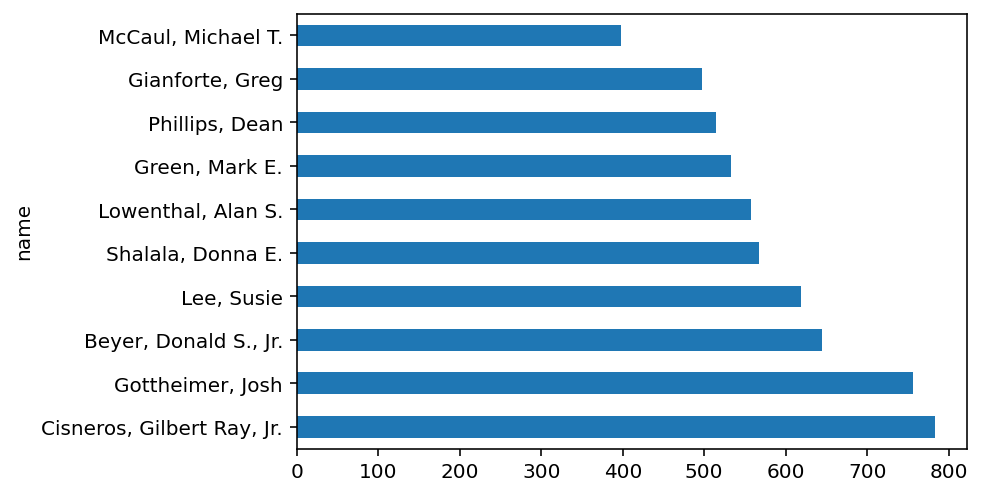

In [32]:
transactions.groupby('name').count()['amount'].sort_values(ascending = False).head(10).plot(kind='barh')

Another question we should ask after seeing this graph is how many of the top 10 are Republicans and how many are Democrats? Is there some kind of correlation among the top 10? Among the larger dataset as a whole? What about third parties?

<AxesSubplot:ylabel='party'>

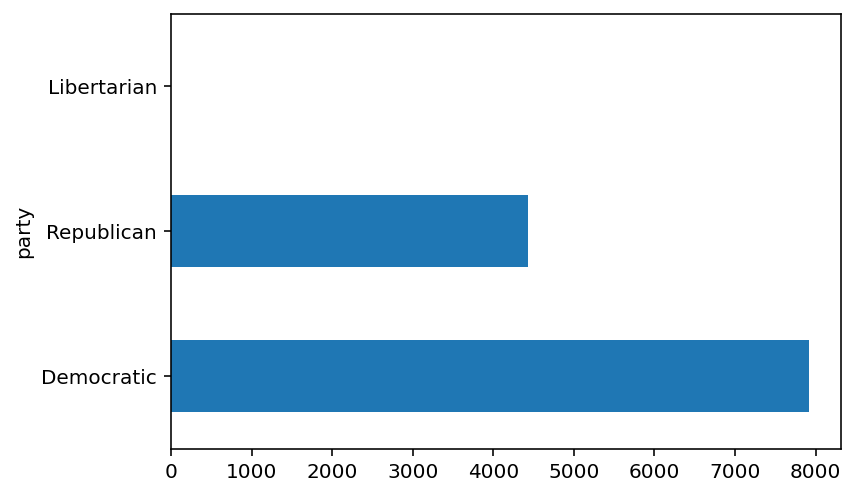

In [33]:
transactions.groupby('party').count()['amount'].sort_values(ascending = False).head(10).plot(kind='barh')

From this perspective it appears as though the Democrats vastly outtrade the Republicans in congress, at least among the top 10. What about the data set in its entirety?

<AxesSubplot:ylabel='party'>

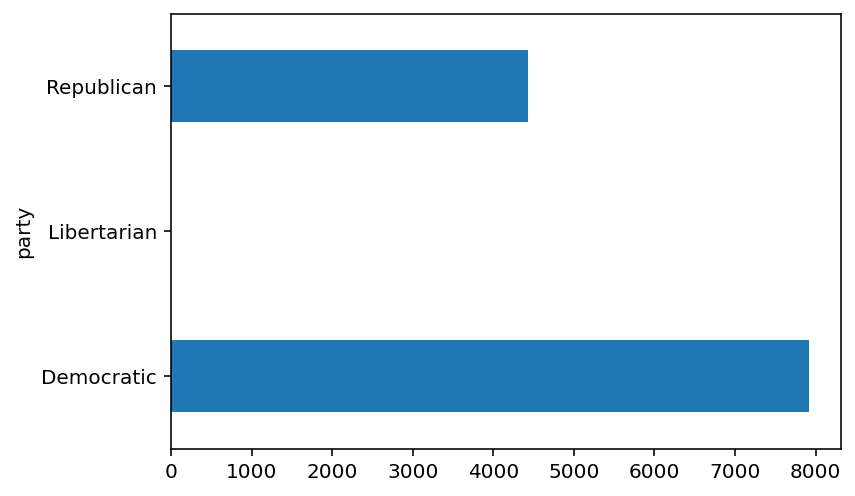

In [34]:
transactions.groupby('party').count()['amount'].plot(kind='barh')

It appears as though Democrats outtrade Republicans not just in the top 10, but also for the dataset in its entirety. While this represents the frequency of trades, let us see which party traded with bigger amounts of money using our min_value column. This is a weaker form of analysis since we're missing an upper bound, and we're also reliant on the congress-person's self-reported data. Ultimately there's no way to be more accurate, so this will have to suffice.

<AxesSubplot:ylabel='party'>

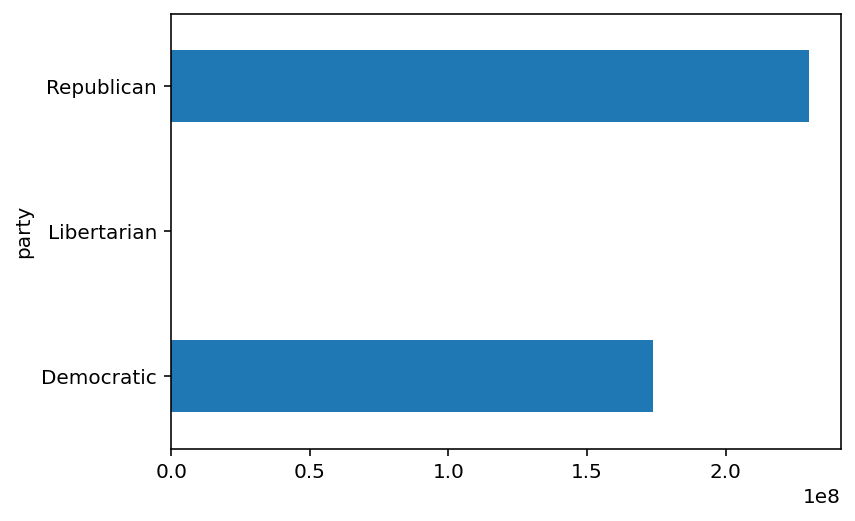

In [35]:
transactions.groupby('party').sum()['min_value'].plot(kind='barh')

This is now a flipped version of the frequency of trades graph. It appears as though while Democrats trade more often, they trade with lower amounts of money (if we assume the minimum possible value in all cases). As mentioned previously, these values are all assumed in many cases thus well-founded and coherent analysis here is not possible.

Since we do know with almost absolute certainty how often each party trades, we can hypothesis test that instead. Although the frequency will not give us insight into how much each party benefits from trading, it can tell us if any members of congress are using insider information to benefit from the market. Overall the pattern of trading across the entire dataset shows the financial habits of congresspeople, and thus if there was a spike in frequency around certain dates, we could demonstrate potential insider trading.

In [36]:
freq = transactions.groupby('transaction_date').count()['amount'].reset_index()
dates_by_party = transactions.groupby(['transaction_date', 'party']).count()['amount'].reset_index()

First, let's look at an aggregate line plot of all parties and their trading on all transaction dates listed in our dataset:

[Text(0.5, 1.0, 'Stock Trades Over Time')]

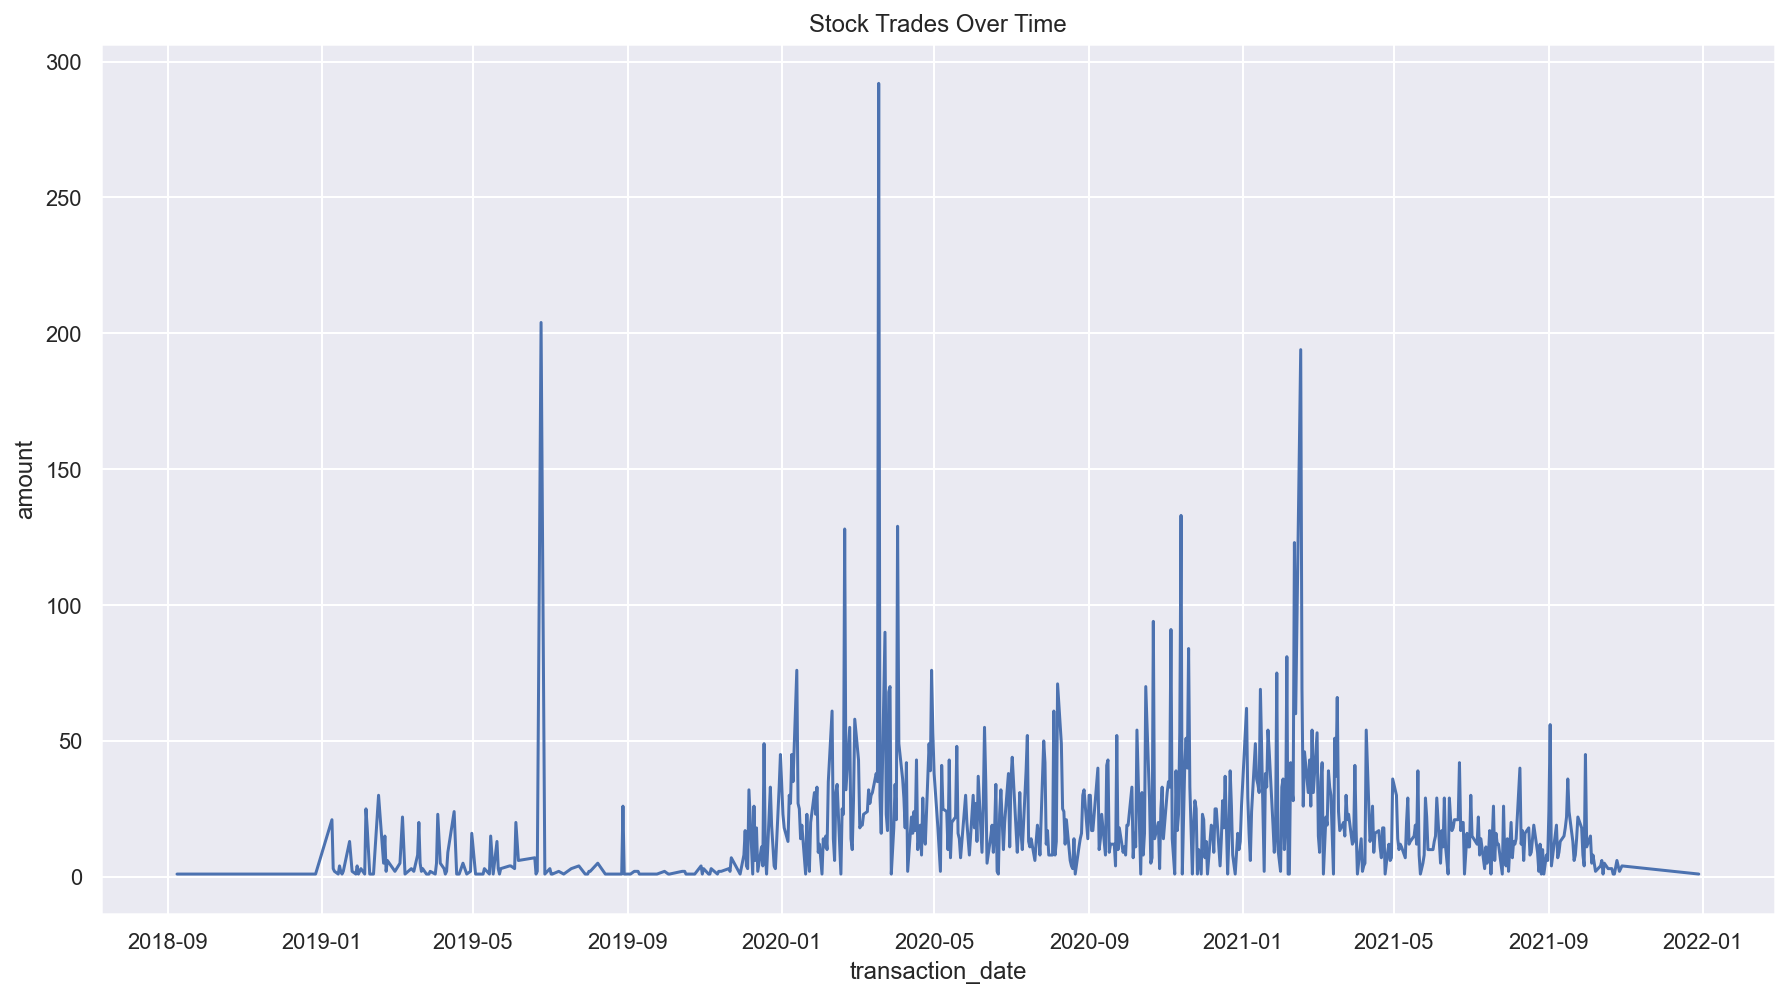

In [37]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=freq, x='transaction_date', y='amount').set(title='Stock Trades Over Time')

It appears as though there were clear spikes around certain days of the year. 3 stand out in particular: One in mid 2019, one in early 2020, and one in early 2021. What days held the most trades? And were these days before major market fluctuations?

In [38]:
transactions.groupby('transaction_date').count()['amount'].sort_values(ascending=False).head(5)

transaction_date
2020-03-18    292
2019-06-24    204
2021-02-16    194
2020-11-13    133
2020-04-02    129
Name: amount, dtype: int64

March 18, 2020 was during the COVID crash, and interestingly on that day a 15 minute US SEC halt was enforced due to a 7% drop in the S&P 500. Although it's evident that the congresspeople did not benefit from selling at this time, there may have still been some forewarning about the halt, and thus the mass sell-off on this day.

https://www.politico.com/news/2020/03/18/stock-plunge-triggers-trading-pause-135792

June 24, 2019 was the Monday after the US Department of Commerce banned 5 Chinese chip-making companies from buying components from the US. So, this was probably not insider trading since it occurred the Monday after the news broke.

https://www.cnbc.com/2019/06/21/chip-stocks-fall-after-commerce-dept-bars-5-more-chinese-firms-from-buying-us-parts.html
https://www.yahoo.com/now/stock-market-news-jun-24-135201387.html

February 16, 2021, was a day nothing really happened in terms of financial markets [REDACTED by Congress]. The only events of note were Biden’s proposed $1.9 trillion Covid-19 relief package and the Texas deep freeze. Maybe splitting the aggregate graph above into one for Democrats, and one for Republicans may help break this down further.

https://www.cnbc.com/2021/02/16/5-things-to-know-before-the-stock-market-opens-february-16-2021.html
https://www.nasdaq.com/articles/stock-market-news-for-feb-16-2021-2021-02-16

[Text(0.5, 1.0, 'Stock Trades Over Time By Party')]

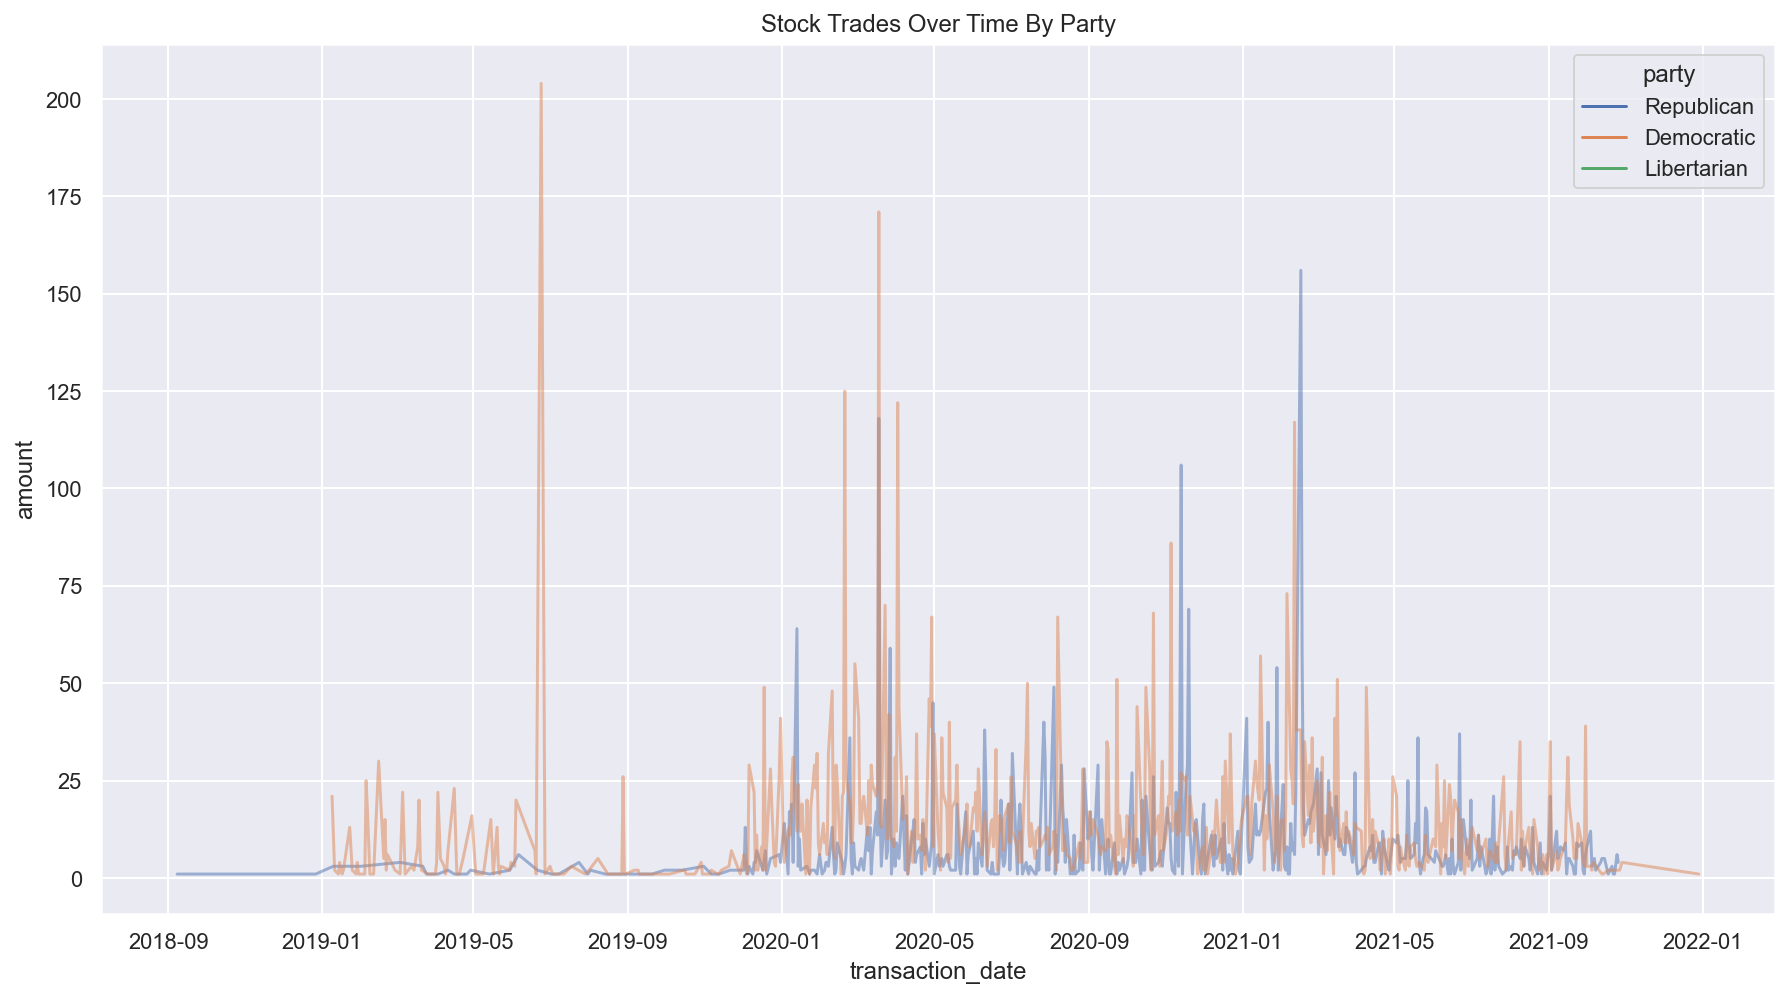

In [39]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=dates_by_party, x='transaction_date', y='amount', hue='party', alpha=0.5).set(title='Stock Trades Over Time By Party')

After looking at the above graph the spike on February 16 of this year looks to have been motivated primarily by Republicans. This makes some sense because Texas is a primarily Republican state, and the deep freeze may have triggered some panic selling. Of course so far we've assumed a lot based on selling vs buying, but it would be more prudent to break our data down into sales and purchases of stock:

[Text(0.5, 1.0, 'Stock Sales Over Time')]

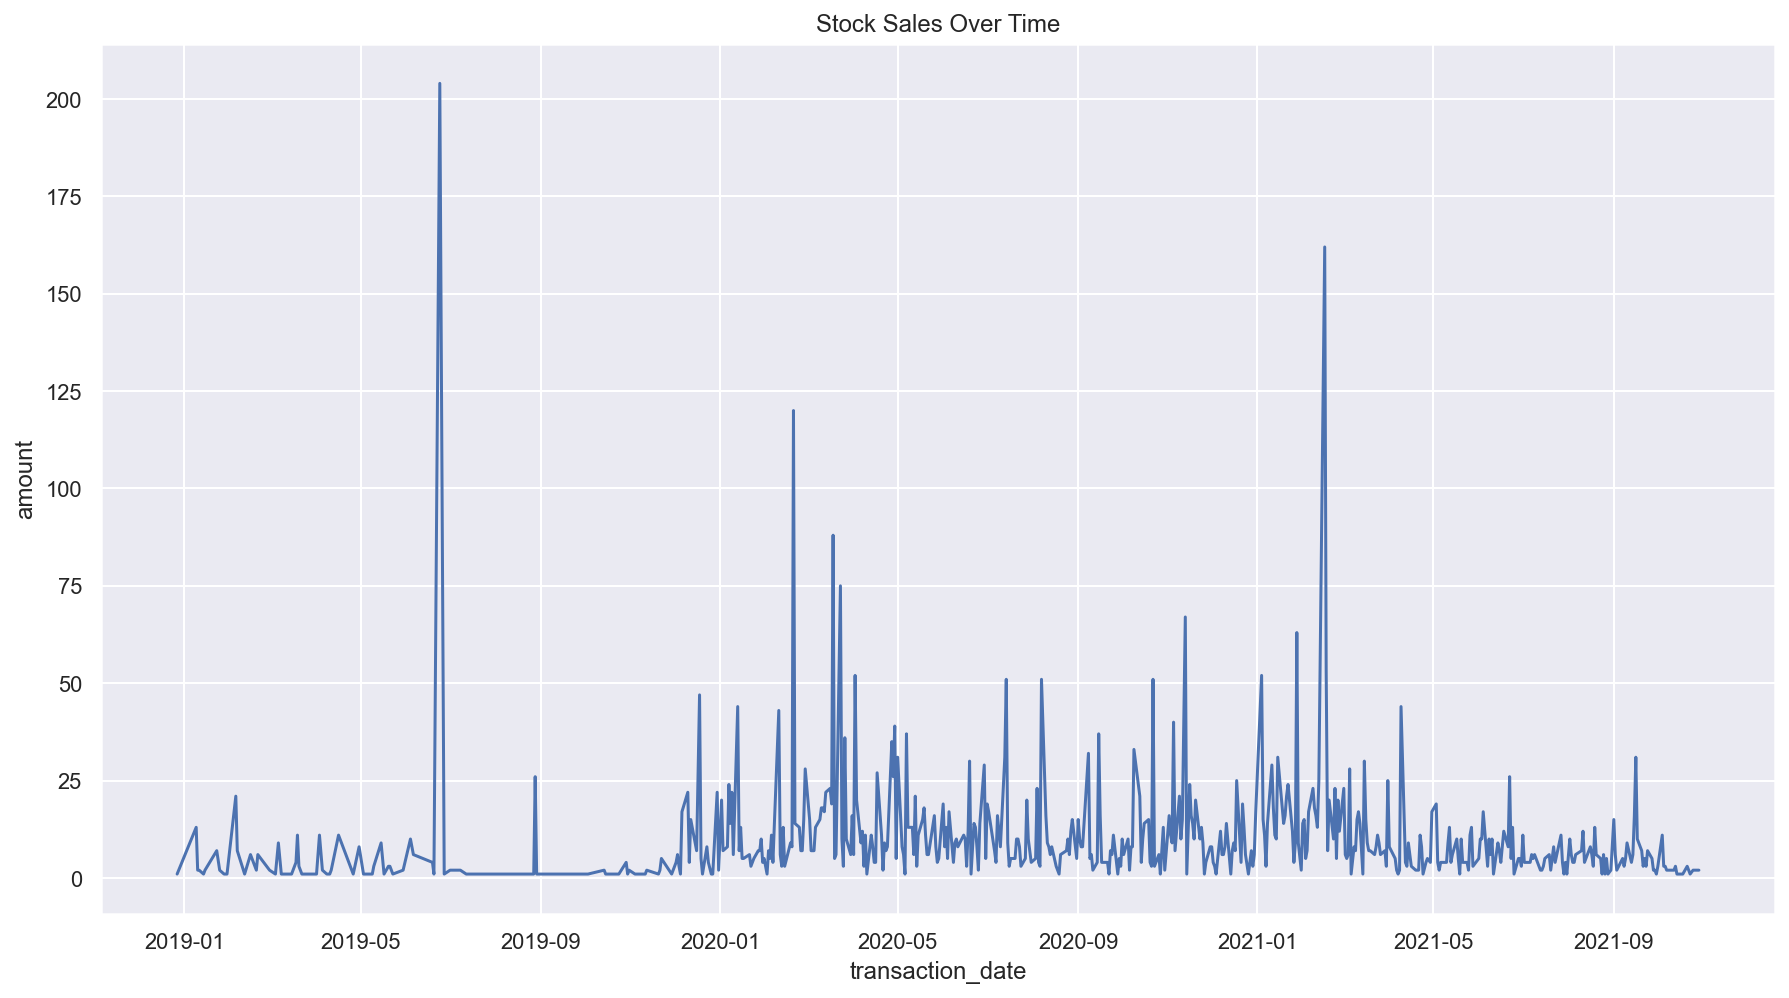

In [40]:
sales = transactions[transactions['type'].str.contains('sale')]
sales_freq = sales.groupby('transaction_date').count().reset_index()
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=sales_freq, x='transaction_date', y='amount').set(title='Stock Sales Over Time')

When we look at selling, there are only two major spikes. What are these dates?

In [41]:
(
    sales.groupby('transaction_date').count()['amount']
 .sort_values(ascending=False).head()
)

transaction_date
2019-06-24    204
2021-02-16    162
2020-02-20    120
2020-03-18     88
2020-03-23     75
Name: amount, dtype: int64

While March 18, 2020 was on our original list of frequencies as the highest date for trading, it appears as though the trades were not mainly sales. Also June 24, 2019 and February 16, 2021 are dates with significant amounts of sales. Could the congress people have been buying on March 18? And who sold the most on either of the two dates that remain?

[Text(0.5, 1.0, 'Stock Sales Over Time By Party')]

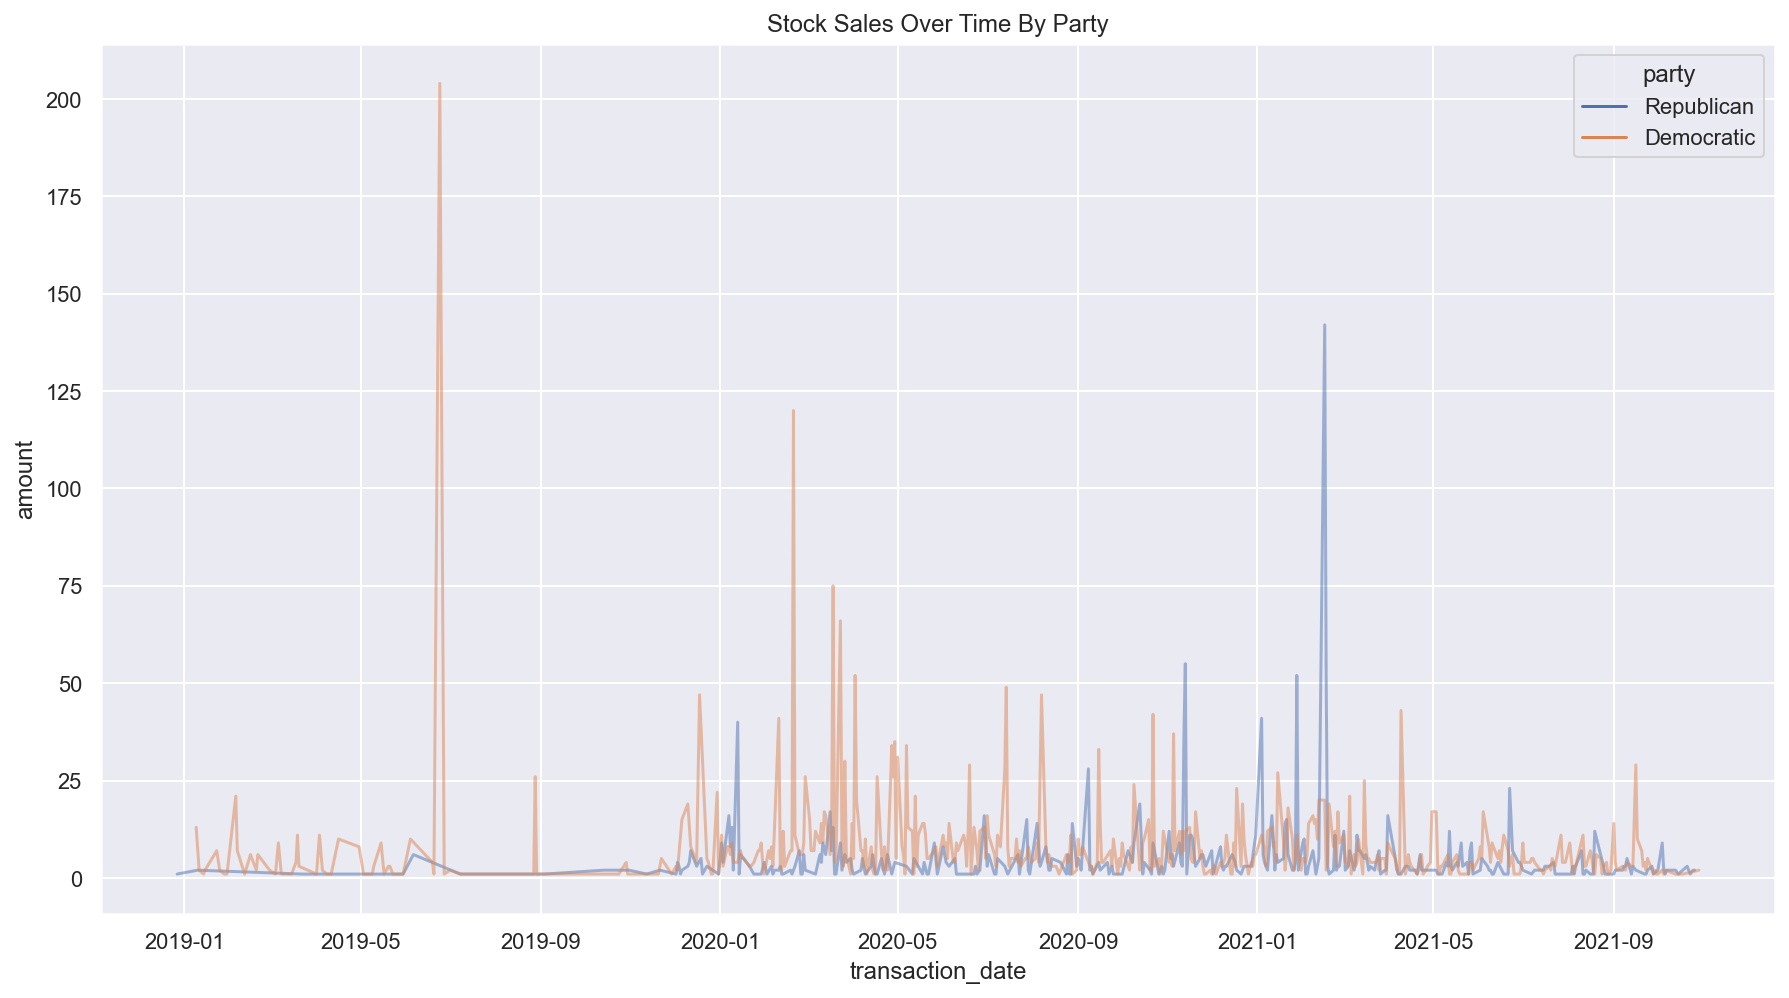

In [42]:
sales_by_date = (transactions[transactions['type']
                              .str.contains('sale')]
                 .groupby(['transaction_date', 'party'])
                 .count()['amount'].reset_index()
                )
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=sales_by_date, x='transaction_date', y='amount', hue='party', alpha=0.5).set(title='Stock Sales Over Time By Party')

So on a party breakdown, it appears as though Democrats sold the most on June 24, 2019 and Republicans sold the most on February 16 of this year. This lends further credence to the idea that Republicans sold the most on the latter day because of the Texas deep freeze: Although we cannot establish causality, these events appear to be correlated. Now let's move on to a quick EDA on buying habits.

[Text(0.5, 1.0, 'Stock Purchases Over Time')]

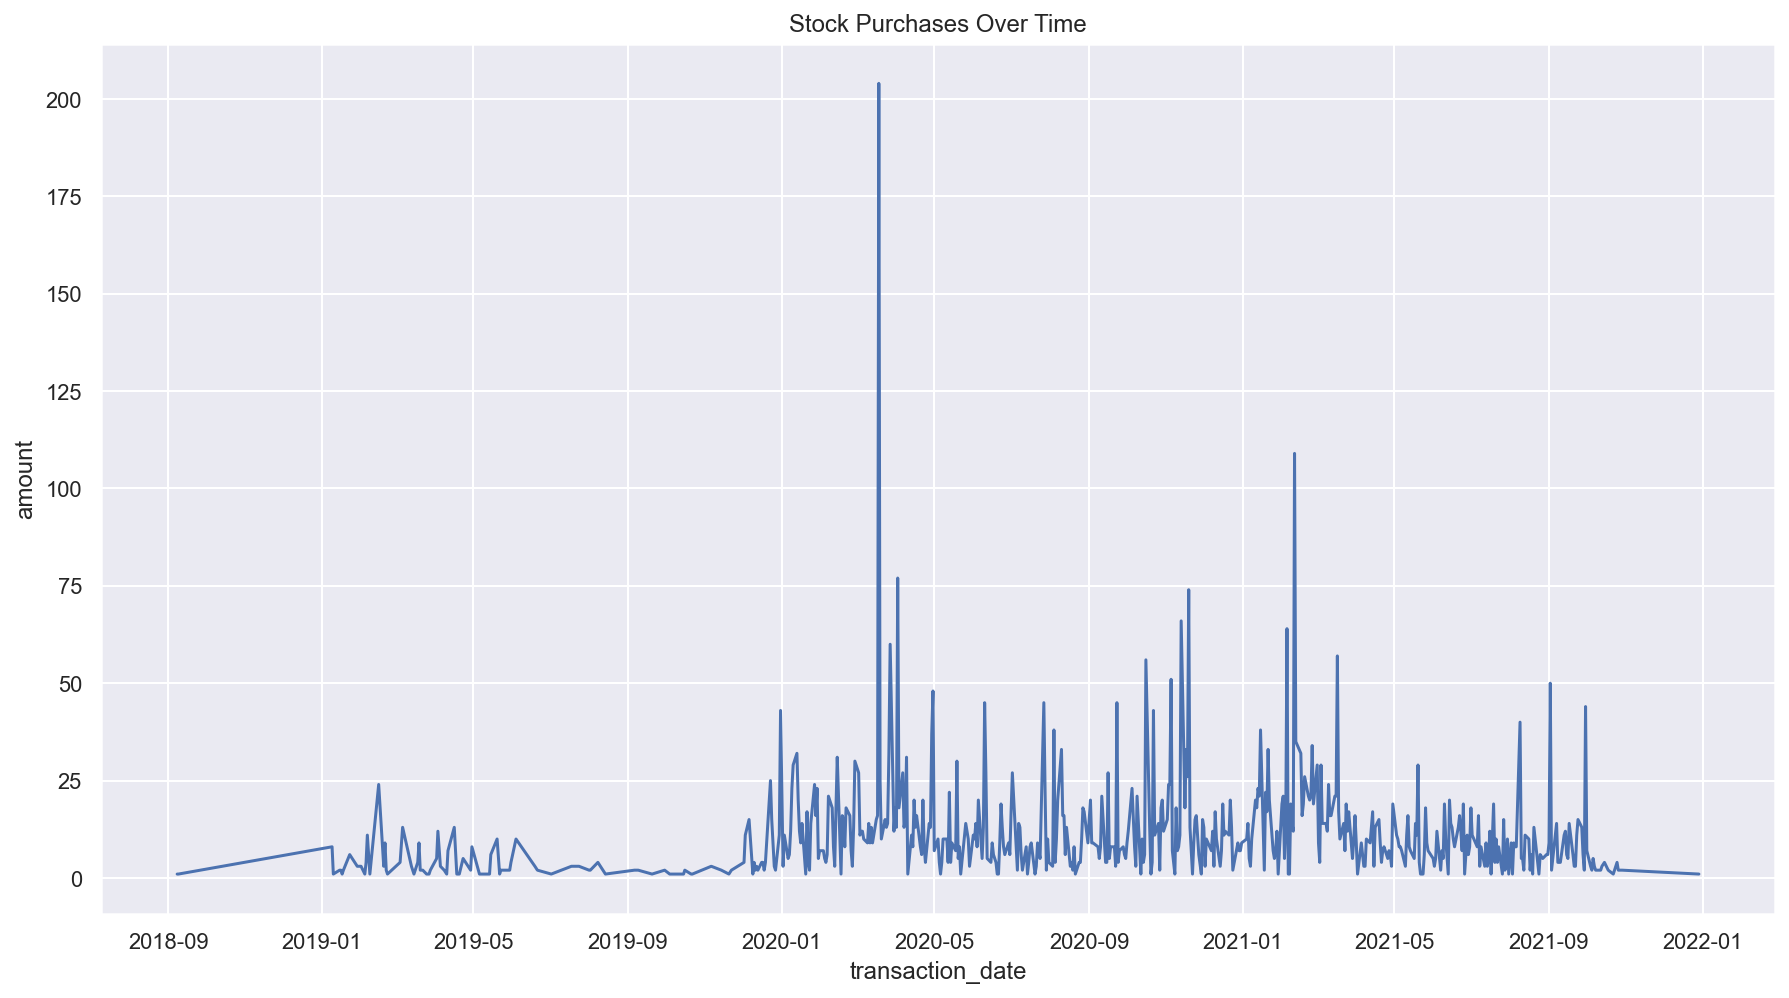

In [43]:
purchases = transactions[transactions['type'].str.contains('purchase')]
purchase_freq = purchases.groupby('transaction_date').count().reset_index()
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=purchase_freq, x='transaction_date', y='amount').set(title='Stock Purchases Over Time')

WOW! It appears as though what we assumed were sales were actually purchases. This appears to be some sign of insider trading; the market was almost at its lowest on March 18, 2020 and the fact that the congress people appear to have known to purchase on that day is quite telling. To be sure let's get the top 5 dates by purchases made.

In [44]:
(
    purchases.groupby('transaction_date').count()['amount']
 .sort_values(ascending=False).head()
)

transaction_date
2020-03-18    204
2021-02-11    109
2020-04-02     77
2020-11-19     74
2020-11-13     66
Name: amount, dtype: int64

It appears as though there were two dates during which a significant volume of purchases were made. The first was March 18, 2020, as expected, and the other was February 11, 2021 which was almost right before the date of Biden's stimulus package. Again, while we cannot establish causation we suspect that there may be a strong correlation between these two events. Let us see which party bought the most during these dates.

[Text(0.5, 1.0, 'Stock Purchases Over Time By Party')]

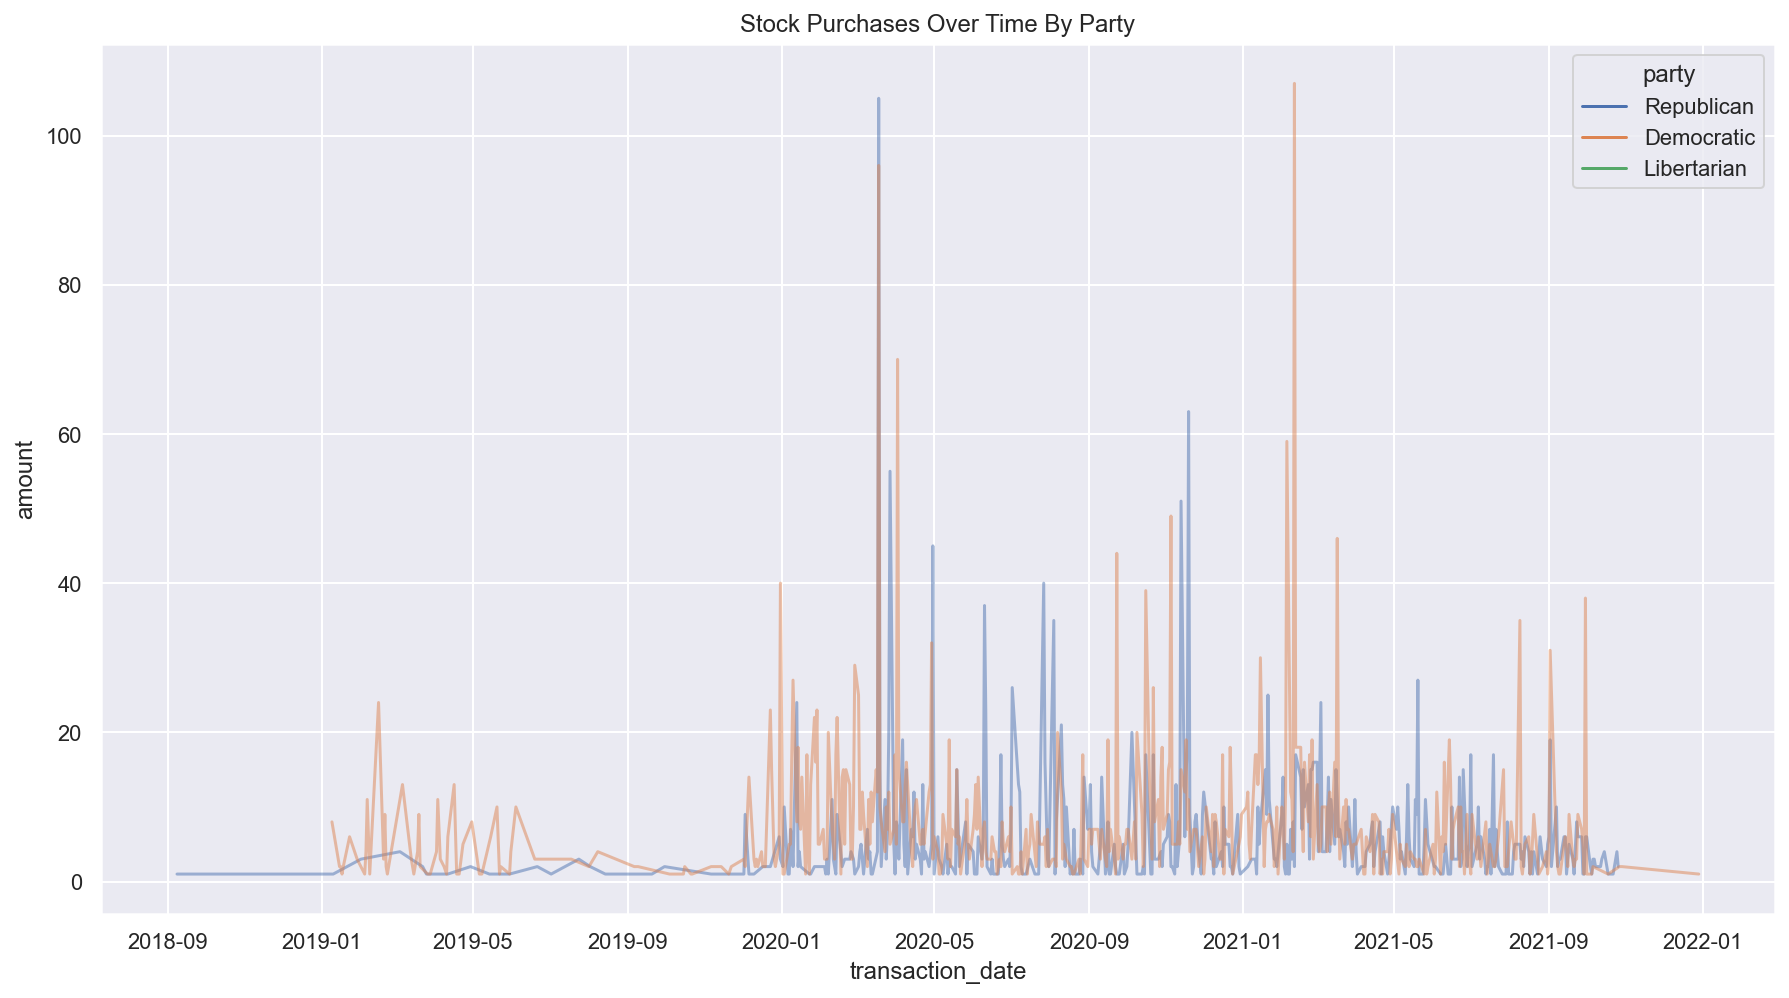

In [45]:
purchases_by_date = (purchases
                 .groupby(['transaction_date', 'party'])
                 .count()['amount'].reset_index()
                )
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=purchases_by_date, x='transaction_date', y='amount', hue='party', alpha=0.5).set(title='Stock Purchases Over Time By Party')

While the buying during COVID appears to have been bi(buy)-partisan, the buying during February 11, 2021was mostly Democratic. This is an interesting development because the stimulus package was a Democratic party endeavor. While we can't prove anything, this behaviour is highly suspicious.

On another multi-faceted note, there appear to be several days where Republicans traded the most, and other days where Democrats traded the most, and in either case, by a large margin. A question for some other exploration could be a question regarding this behaviour: Why are there so few days where both parties trade equally?

Since we now know when trading spiked, we have opened a few avenues of investigation. One of the limitations of our previous analysis is that all of the trading could be tied to one or two congress members. It wouldn't be fair to every congress person if we didn't consider the fact that each row in our dataset is tied to a single person. We can begin by looking at who bought the most on March 18, 2020:

In [46]:
purchases[purchases['transaction_date'] == '2020-03-18'].groupby('name')['amount'].count().sort_values(ascending=False).head(5)

name
Gianforte, Greg               102
Cisneros, Gilbert Ray, Jr.     91
Amash, Justin                   3
Lowenthal, Alan S.              2
Comer, James                    1
Name: amount, dtype: int64

While our initial reaction was to consider every member of every party complicit, this breakdown clearly shows that only two members of each party sent in a significantly high number of purchase orders. Of course this only demonstrates frequency. Due to the fact that we don't have the exact value of each purchase, we could be overlooking a single extremely large trade. We can still look at this from a cursory perspective with the lowest possible value of each transaction:

In [47]:
purchases[purchases['transaction_date'] == '2020-03-18'].groupby('name')['min_value'].sum().sort_values(ascending=False).head(5)

name
Gianforte, Greg               459102
Cisneros, Gilbert Ray, Jr.    105091
Amash, Justin                  17003
Lowenthal, Alan S.              2002
Comer, James                    1001
Name: min_value, dtype: int64

From this perspective it becomes evident that only two members of congress really purchased significant amounts of stock. However both are among our top 10 for trading frequency as a whole. Is this really unusual behaviour for them? This may be a question worth hypothesis testing. In the meantime let's look at another date. Say February 11, 2021:

In [48]:
purchases[purchases['transaction_date'] == '2021-02-11'].groupby('name')['amount'].count().sort_values(ascending=False).head(5)

name
Khanna, Ro            100
Lee, Susie              3
Newman, Marie           3
McCaul, Michael T.      2
Peters, Scott H.        1
Name: amount, dtype: int64

Interestingly the name at the top of this list is not among our top 10 for stock trading as a whole. However these could all be small order purchases, and we could be flagging unsuspicious behaviour. So:

In [49]:
purchases[purchases['transaction_date'] == '2021-02-11'].groupby('name')['min_value'].sum().sort_values(ascending=False).head(5)

name
McCaul, Michael T.    1000002
Khanna, Ro             394100
Peters, Scott H.       100001
Newman, Marie           66003
Lee, Susie               3003
Name: min_value, dtype: int64

Surprisingly our representative with the most value now changes. He's now the person with the second most valuable trades, if our modus operandi of taking the minimum possible value is reflective of the truth whatsoever, which it is likely not. Still one representative had a single significantly large transaction on this day. This is quite suspicious in of itself. Let's find out what assets he traded on February 11, 2021.

In [50]:
feb_11 = purchases[purchases['transaction_date'] == '2021-02-11']
feb_11[feb_11['name'] == 'McCaul, Michael T.']['asset_description'].unique()

array(['pimco short asset investment fund institutional class',
       'pimco short asset investment fund intuitional class'],
      dtype=object)

The breakdown shows that not all party members may be complicit in so-called "insider trading", and that only several notable members are responsible for the majority of trade volumes on these certain dates. 

Thus, given that our exploratory analysis shows intriguing results for several members of Congress, we can pose several hypotheseses around their behavior on dates that may implicate them in "insider trading".

### Assessment of Missingness

Let's begin by examining which columns within our cleaned dataset have missingness.

In [51]:
transactions.isna().sum()

disclosure_year              0
disclosure_date              0
transaction_date             0
owner                     5844
ticker                    1023
asset_description            0
type                         0
amount                       0
representative               0
district                     0
ptr_link                     0
cap_gains_over_200_usd       0
name                         0
party                        0
min_value                    0
dtype: int64

Our current strategy for tickers is to ignore the ticker and instead use the asset description wherever we can. The ticker is currently hypothesized to be NMAR after some brief exploration of some missing tickers: Missing dependent upon if the asset is listed on the NASDAQ. This can be further proven by understanding that the collection process populates the form according to NASDAQ tickers. 

Our cleaned dataset has only two columns with missingness to be evaluated. Specifically, owner and ticker, which describe the account type and stock market abbreviation for the asset respectively.

Ticker, could be NMAR, as we hypothesize that the generated ticker is reliant on its existence in the NASDAQ. However, given that asset description has no missing values, we can say that ticker is also likely MAR on the asset description. Given the limiations of our ability to clean the asset descriptions, we cannot establish if this would be missing by design due to inconsistencies in asset reporting generated by the handwriting and other forms of input to this column. 

Owner, we hypothesize to be MCAR with the minimum value of the trade. After sifting through multiple Congress asset reports, we failed to find any obvious correlations between the account type(denoted by owner) and the amount of transaction. However, we hypothesize it to be MAR with the represenative's name given that the type of account owned should be tied to who the representative selects to manage their account. 

 To test this, we'll be running a permutation test by permuting the missingness of the ticker column and seeing how often we get a total variation distance as the observed. This will be done with a significance level of 0.01 or 1%, considering the size of our dataset and the gravity of assessing so-called "insider-trading".
 
 $H_0$: The distribution of our missing and non-missing data come from the same distribution. In other words, the missingness is MCAR. 
 
 $H_A$: The distribution of our missing and non-missing data does not come from the same distribution. In other words, the missingness is MAR. 

Given that ticker the abbreviation of an asset description, we hypothesize that its missingness would also be based on asset description.

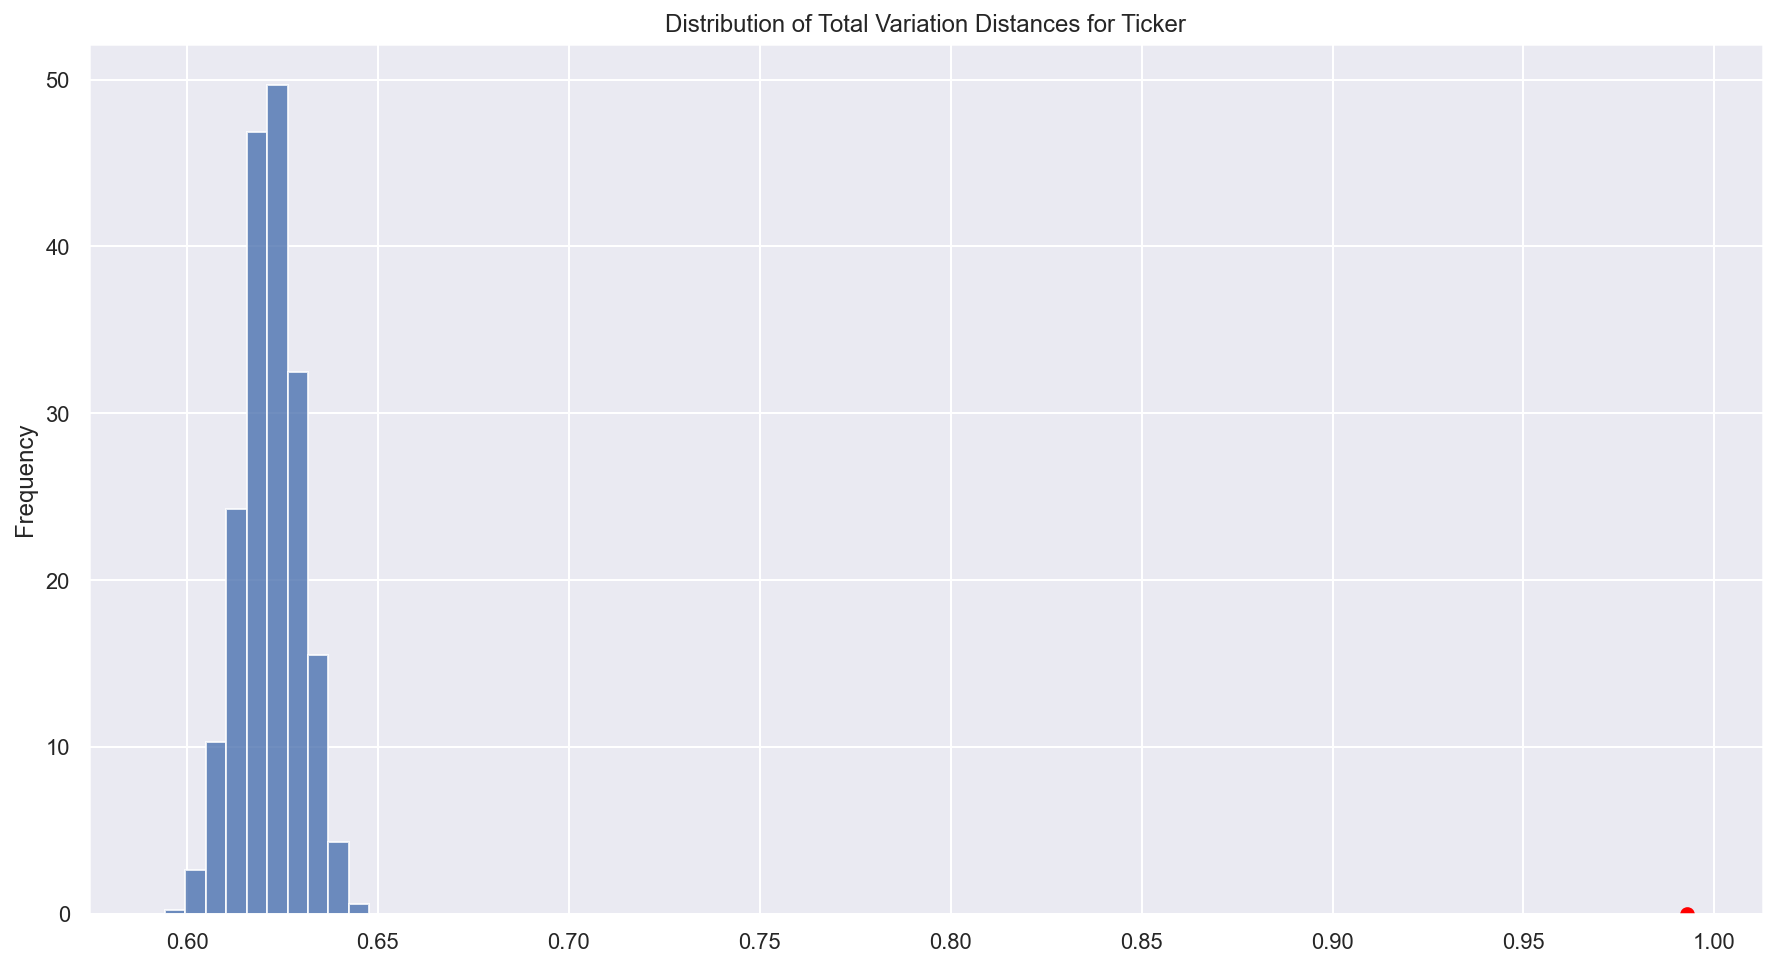

In [52]:
ticker_permtest = transactions.loc[:, ['ticker', 'asset_description']]
ticker_permtest["ticker_isnull"] = ticker_permtest["ticker"].isnull()
dists, obs = hypoth_testing.permutation_test(ticker_permtest, "asset_description", "ticker_isnull", hypoth_testing.tvd)
pd.Series(dists).plot(kind='hist', density=True, alpha=0.8, title="Distribution of Total Variation Distances for Ticker")
plt.scatter(obs, 0, color='red', s=40);

Although our visual plots confirm that we can reject the null hypothesis, and that the data is likely MAR, the p-value is shown below.

In [53]:
pval = (dists >= obs).mean()
pval

0.0

We can run a similar permutation test to assess the missingness of the owner. Given that owner specifies the type of the account, we hypothesize that the min value, which is generated from the transaction amount, will not affect the missingness given that it is likely that representatives have a low number of accounts. 

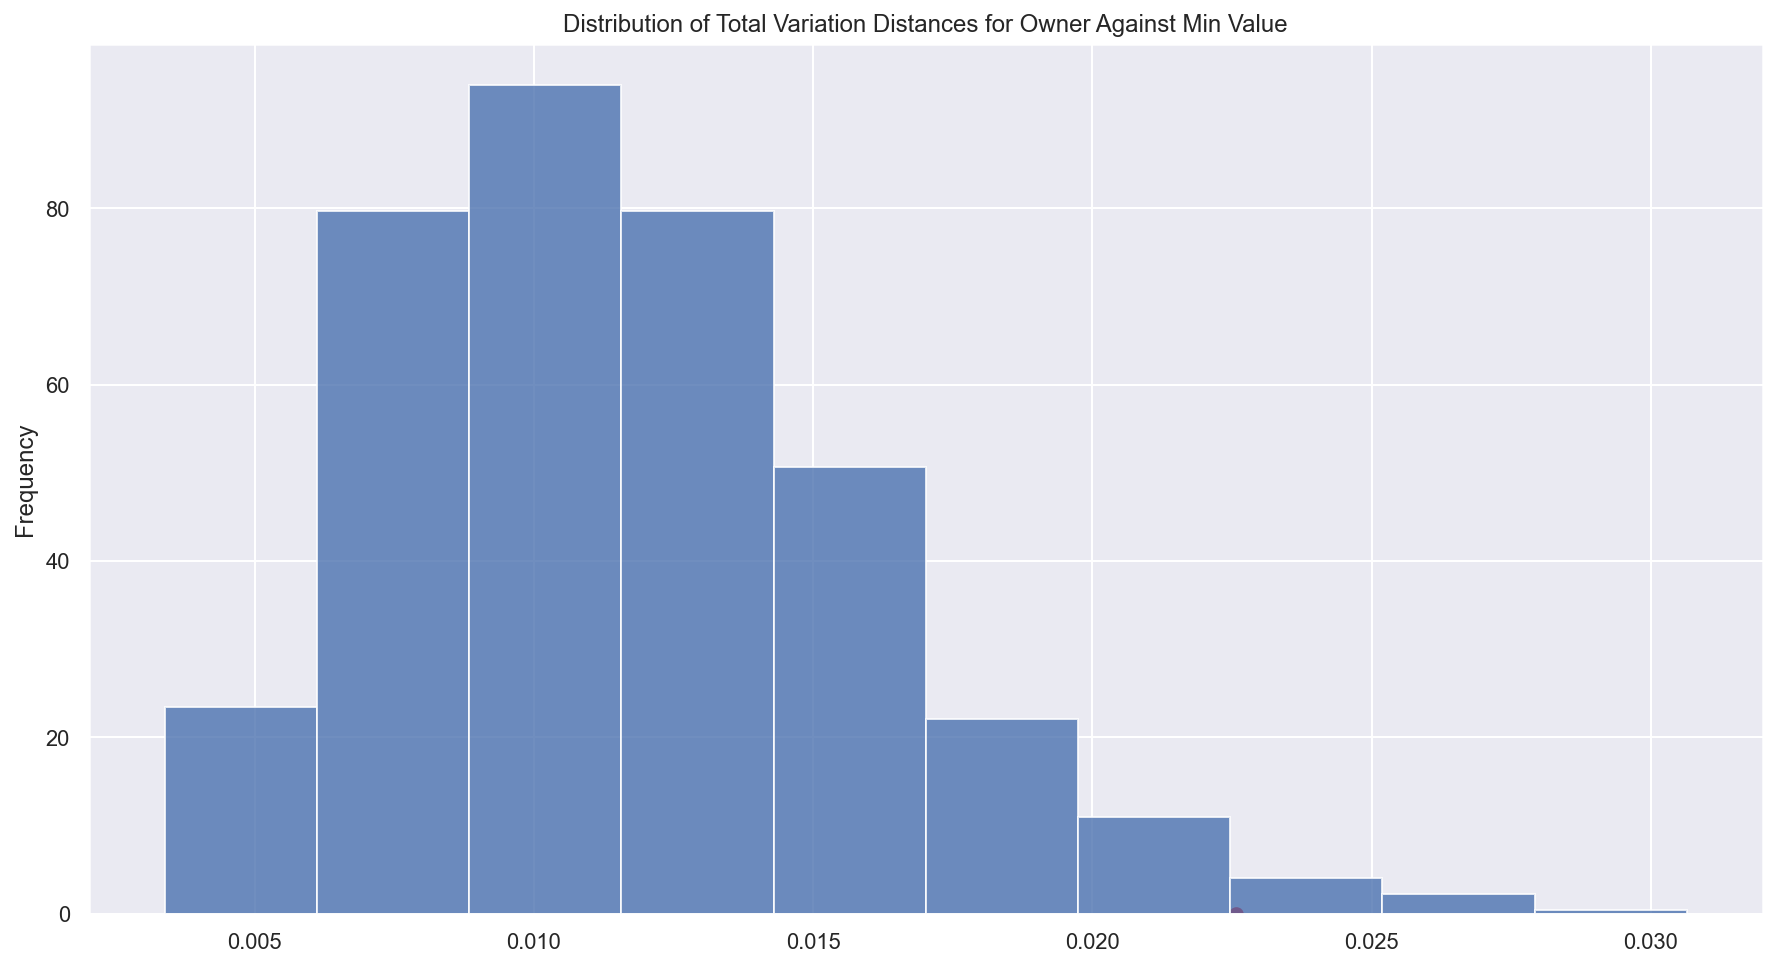

In [54]:
owner_permtest = transactions.loc[:, ['owner', 'min_value']]
owner_permtest["owner_isnull"] = owner_permtest["owner"].isnull()
dists, obs = hypoth_testing.permutation_test(owner_permtest, "min_value", "owner_isnull", hypoth_testing.tvd)
pd.Series(dists).plot(kind='hist', density=True, alpha=0.8, title="Distribution of Total Variation Distances for Owner Against Min Value")
plt.scatter(obs, 0, color='red', s=40);

Once again, the p-value is displayed for clarity. It shows that with a significance level of 1%, the missingness of owner is MCAR with the minimum value of the trade.

In [55]:
pval = (dists >= obs).mean()
pval

0.018

However, given that the type of the account should be dependent on who the representative is, we hypothesize that the missingness will also be dependent on that column.

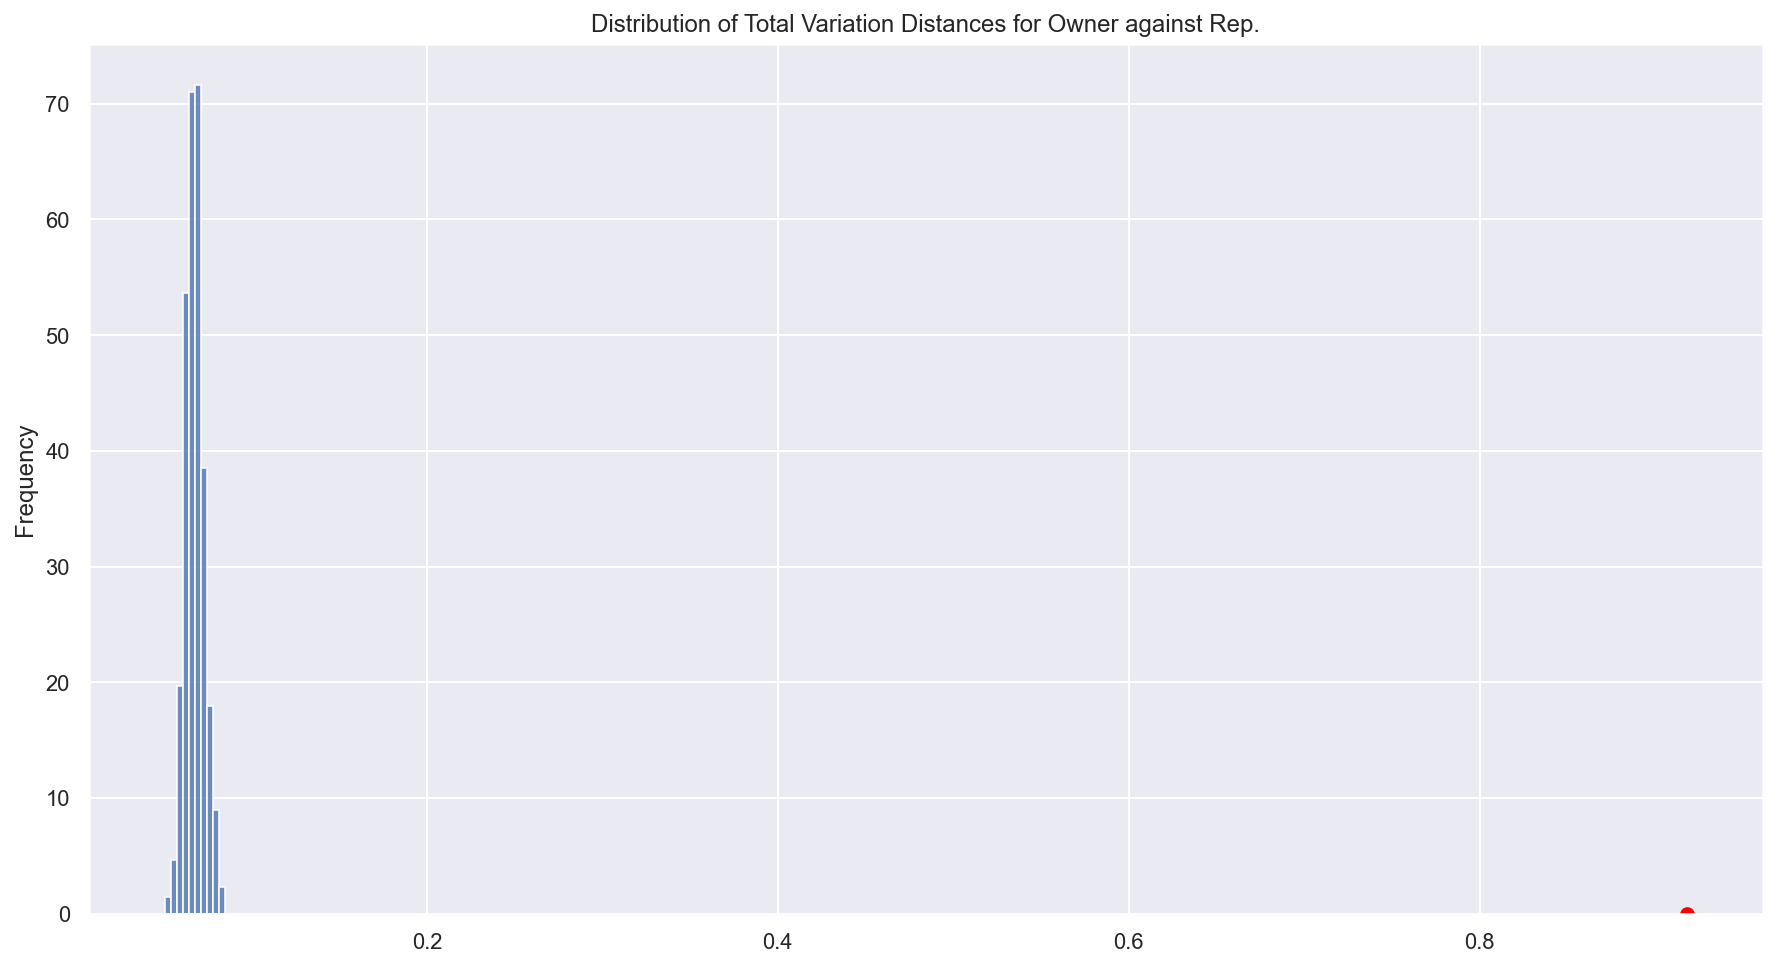

In [56]:
owner_permtest = transactions.loc[:, ['owner', 'representative']]
owner_permtest["owner_isnull"] = owner_permtest["owner"].isnull()
dists, obs = hypoth_testing.permutation_test(owner_permtest, "representative", "owner_isnull", hypoth_testing.tvd)
pd.Series(dists).plot(kind='hist', density=True, alpha=0.8, title="Distribution of Total Variation Distances for Owner against Rep.")
plt.scatter(obs, 0, color='red', s=40);

Given the low variation in total variation distance, and the comparitively large observed variation, we can safely surmise that missingness of owner is dependent on the owner of the account, the representative, with a p-value of 0.

In [57]:
pval = (dists >= obs).mean()
pval

0.0

### Hypothesis Test / Permutation Test

From our exploratory data analysis came several questions of interest:

1. Do the parties have different fiancial habits, as described by their trading volume? Differences in trading volume by party could demonstrate collusive insider trading (if every member of either party follows the same non-uniform distribution, that would be cause for concern). 

2. Given the potential opportunity for inside trading on March 18th, 2020 did Greg Gianforte and Gilbert Ray Cisneros Jr. trade in unusually high volumes when compared to their own average trading across the time period within the dataset?

3. Similarly, on February 11, 2021 did Ro Khanna take advantage of information and trade in unusually high volumes when compared to his own average trading across the time period within the dataset? 

Our first question can be determined by assembling the volume of trades for each party for each date, and then calculating the tvd between the distribution of volumes of trading for each party. If both parties have the same or really similar financial habits, then we shouldn't see a low p-value. If they do not have similar trading habits, then we should see a high p-value. In other words, after setting an $\alpha$ of 0.01:

$H_0$: The distribution of Republican trading volumes and the distribution of Democratic trading volumes are drawn from the same distribution. 

$H_A$: The distribution of Republican trading volumes and the distribution of Democratic trading volumes are not drawn from the same distribution.

In the below cell we transform our dataset into one that we can permute to find financial habits, by creating trading counts for each day of the data set.

In [58]:
trading_volumes = purchases.groupby(["transaction_date", "party"]).count().reset_index()[['amount', 'party']]

In the below visualization we opt to show our graph in log space since our histogram is heavily right skewed. This ultimately allows for a clearer demonstration of the distribution. 

<AxesSubplot:xlabel='amount', ylabel='Count'>

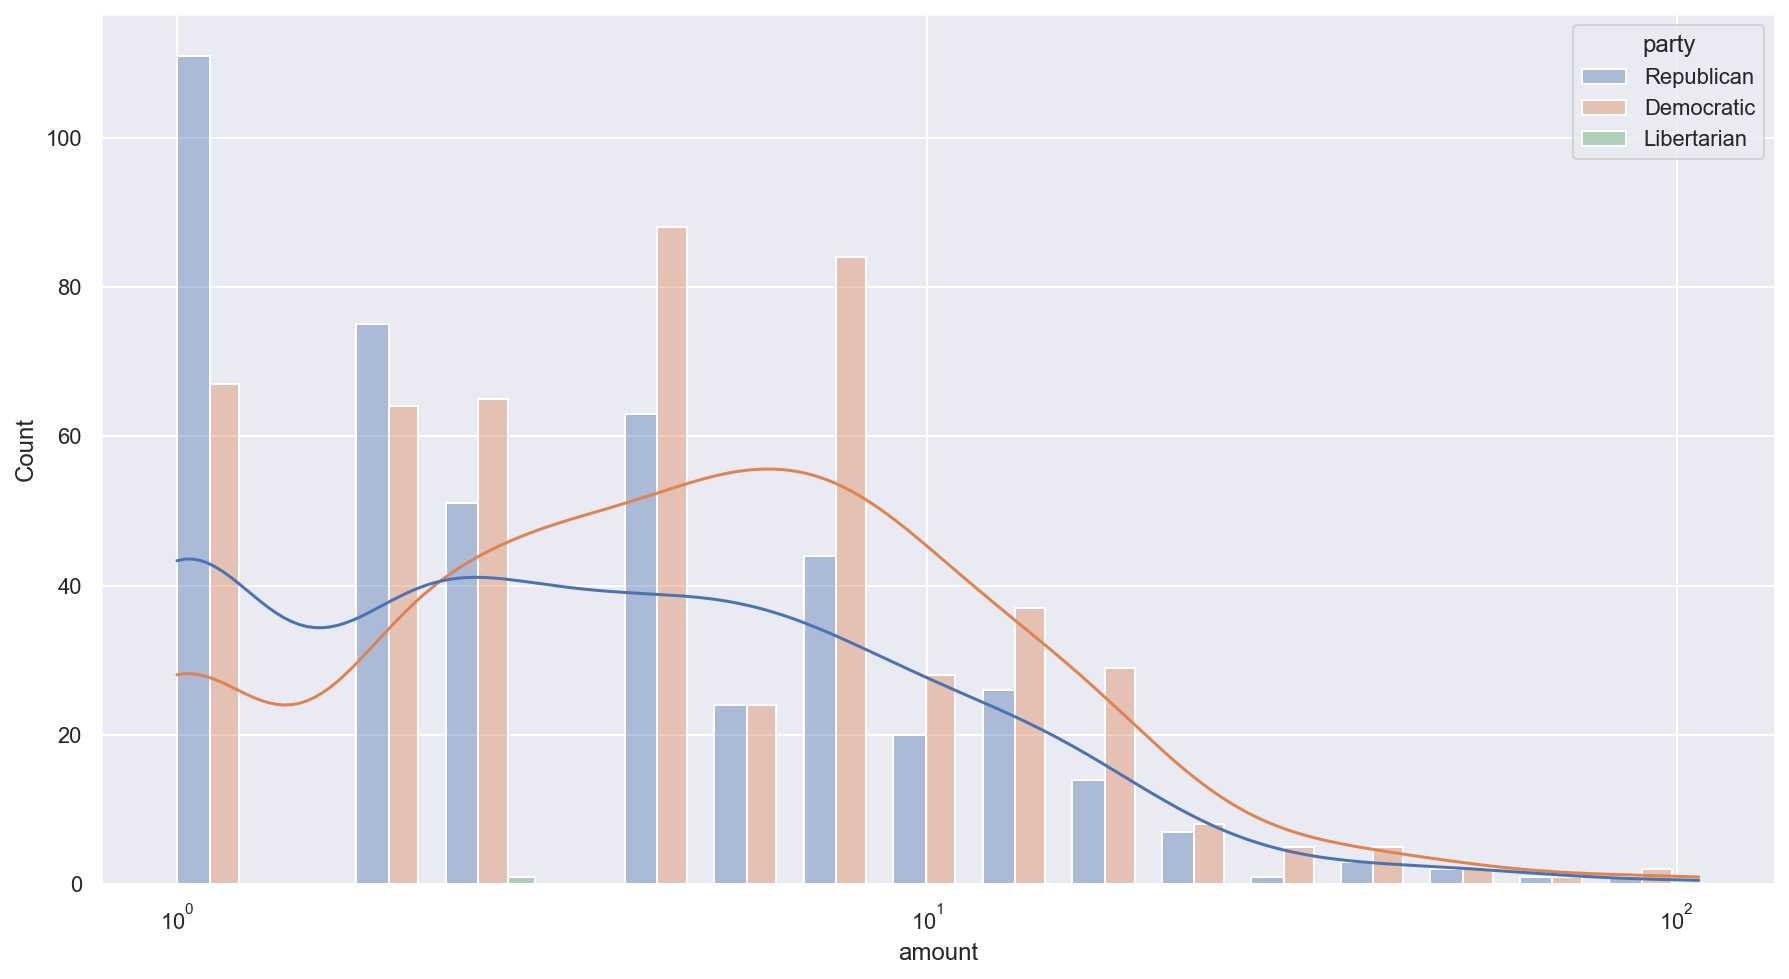

In [59]:
sns.histplot(data=trading_volumes, x='amount', hue='party', alpha=0.4, kde=True, multiple='dodge', log_scale=True)

In the below 3 cells we run our hypothesis/permutation test, visualize our distribution of total variation distances and our observed test statistic as a red dot, and then finally calculate our p-value:

In [60]:
dists, obs = hypoth_testing.permutation_test(trading_volumes, "amount", "party", hypoth_testing.tvd)

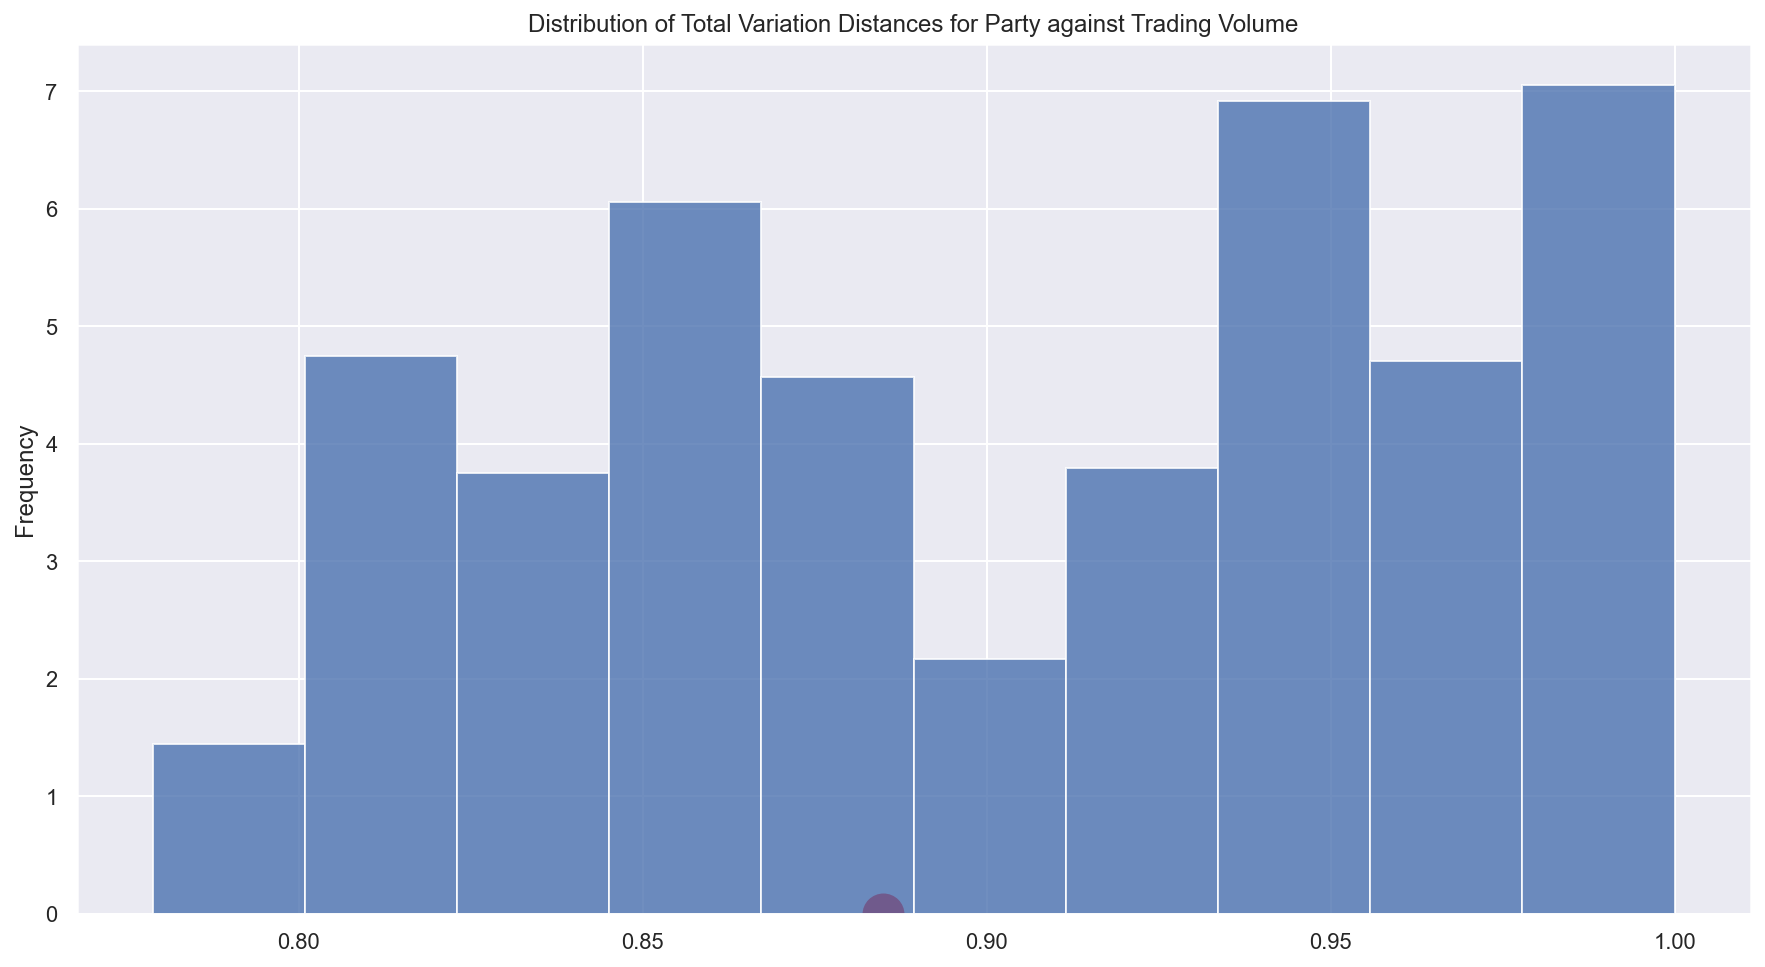

In [61]:
pd.Series(dists).plot(kind='hist', density=True, alpha=0.8, title="Distribution of Total Variation Distances for Party against Trading Volume")
plt.scatter(obs, 0, color='red', s=400);

In [62]:
pval = (dists >= obs).mean()
pval

0.568

Since our p-value far exceeds our alpha of 0.01, we have insufficient support for the alternative hypothesis, and cannot reject the null hypothesis. Ultimately this demonstrates that members of both parties have similar trading patterns, which in turn could imply, with some further testing, that any insider trading will come from outliers of both parties. 

Our second question can be answered by permuting Gianforte's trading volume against all the transaction dates on which he's traded. This has the effect of simulating a normal trading pattern for him, and then, with the right test statistic determining if the number of trades he made on March 18, 2020 was unusual. We'll set an $\alpha$ of 0.01, because this is a significant implication and it wouldn't be right to level it on somebody who is completely innocent:

$H_0$: The number of trades Gregory Gianforte made on March 18, 2020 was drawn from the same distribution as the number trades he made on every other day. 

$H_A$: The number of trades Gregory Gianforte made on March 18, 2020 was drawn from a distribution with greater values than the number of trades he made on every other day. 

In the cell below we define our test statistic which is essentially finding the number of trades made on that day every time we permute. The goal is to find out how many times we see the same value or greater. 

In [63]:
def get_trades(data, col, group_on, date='2020-03-18'):
    return data[data[group_on] == date][col].iloc[0]

In [64]:
trading_volumes = purchases.groupby(["transaction_date", "name"]).count().reset_index()
gianforte_trades = trading_volumes[trading_volumes['name'].str.contains('Gianforte')]

dists, obs = hypoth_testing.permutation_test(gianforte_trades, "amount", "transaction_date", get_trades)

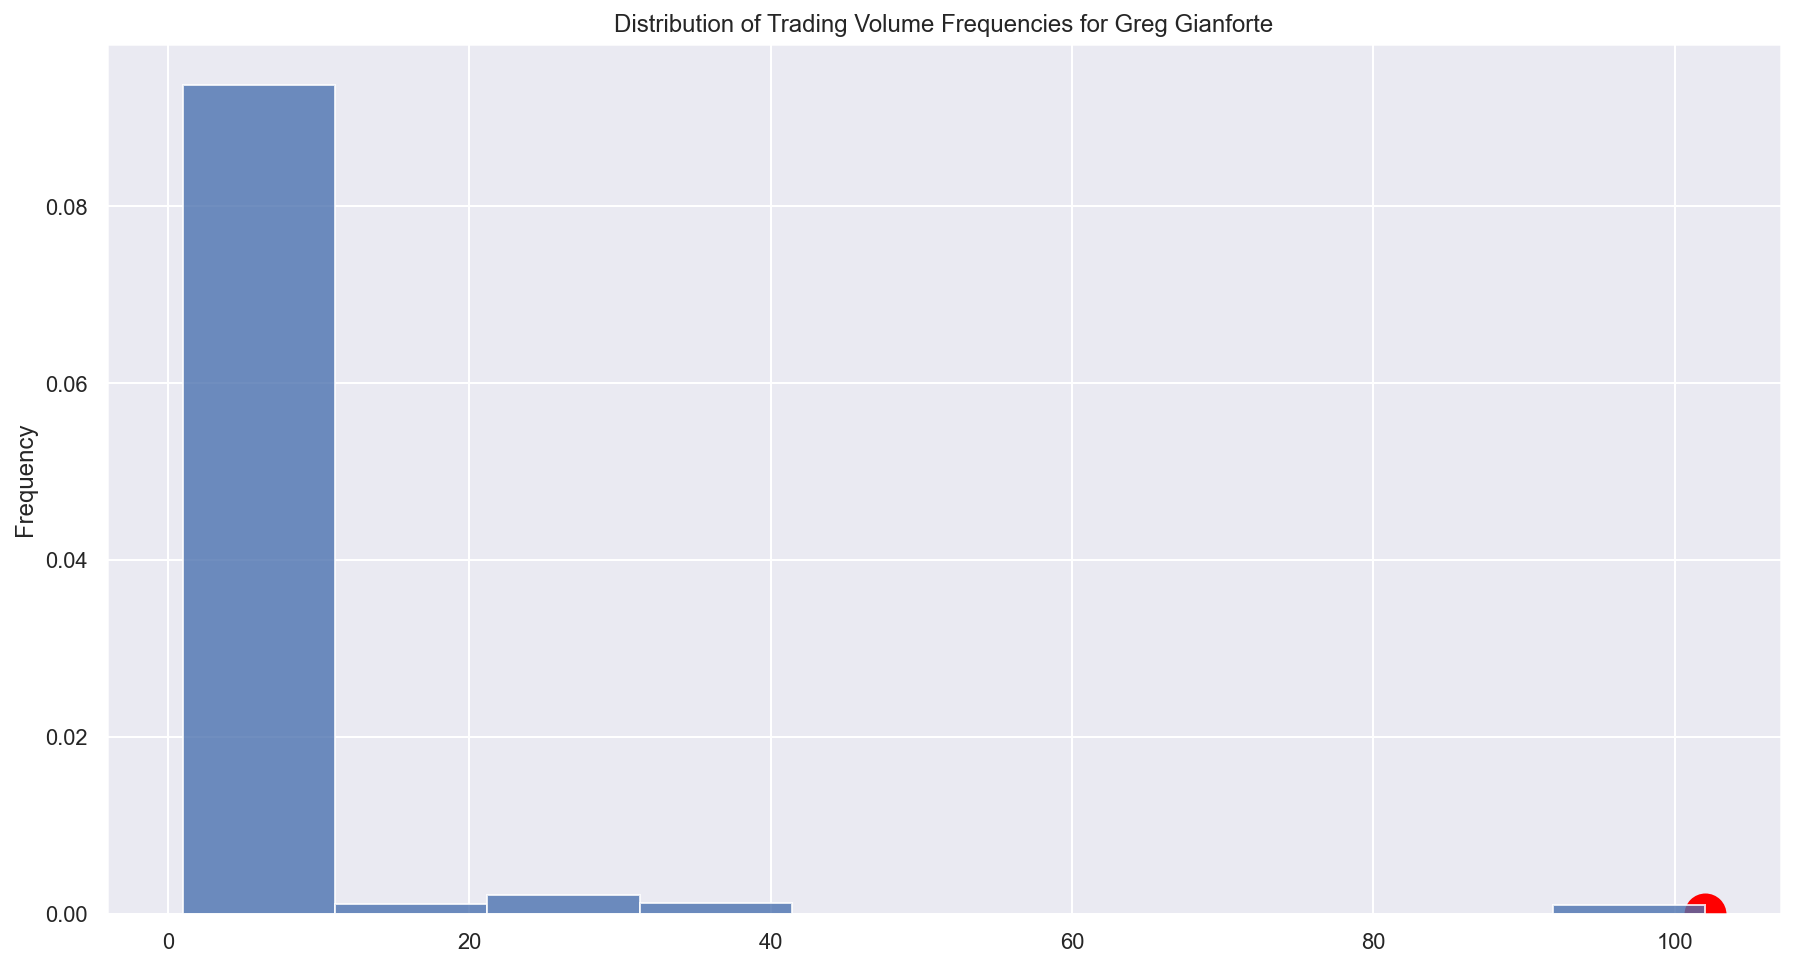

In [65]:
pd.Series(dists).plot(kind='hist', density=True, alpha=0.8, title="Distribution of Trading Volume Frequencies for Greg Gianforte")
plt.scatter(obs, 0, color='red', s=400);

In [66]:
pval = (dists >= obs).mean()
pval

0.01

Our p-value exceeds our stated level of significance, so we cannot reject the null hypothesis and find insufficient support for the alternative hypothesis.

We can now repeat this same hypothesis test for Gilbert Cisneros, another member of congress with an unusually high number of trades on March 18, 2020. Using the same $\alpha$ of 0.01, we will set our null and alternative hypothesis as follows:

$H_0$: The number of trades Gilbert Cisneros made on March 18, 2020 was drawn from the same distribution as the number trades he made on every other day. 

$H_A$: The number of trades Gilbert Cisneros made on March 18, 2020 was drawn from a distribution with greater values than the number of trades he made on every other day. 

In [67]:
trading_volumes = purchases.groupby(["transaction_date", "name"]).count().reset_index()
cisneros_trades = trading_volumes[trading_volumes['name'].str.contains('Cisneros')]

dists, obs = hypoth_testing.permutation_test(cisneros_trades, "amount", "transaction_date", get_trades)

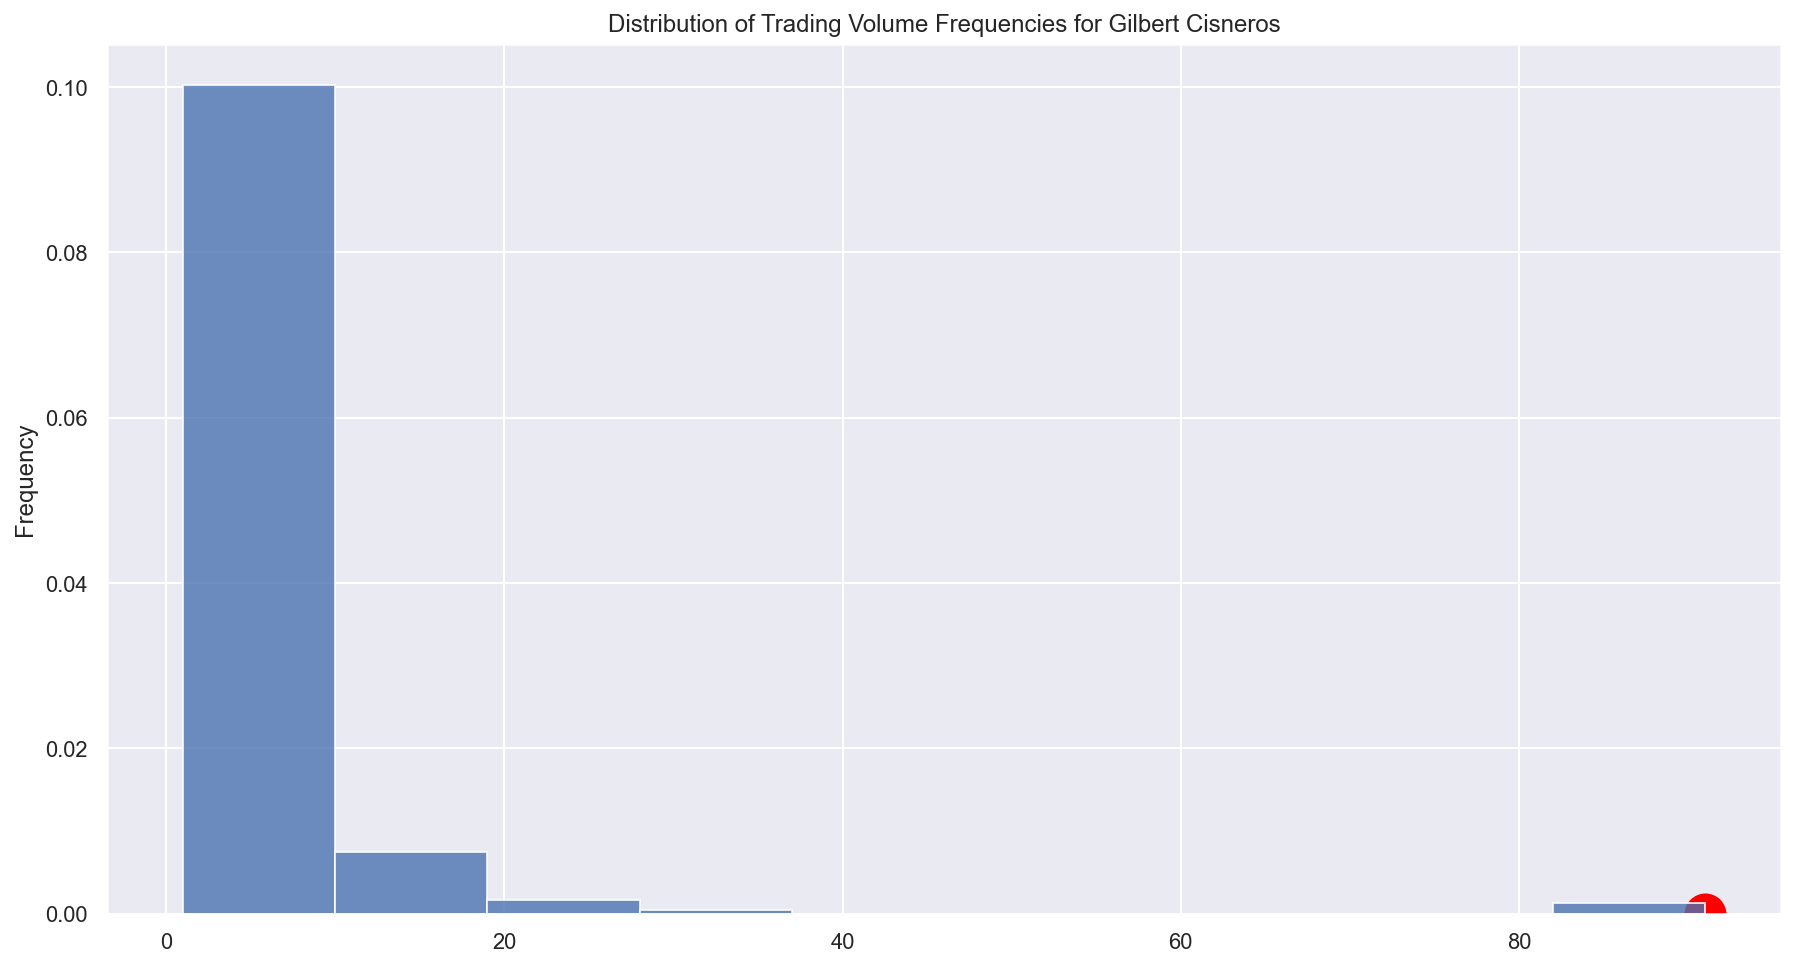

In [68]:
pd.Series(dists).plot(kind='hist', density=True, alpha=0.8, title="Distribution of Trading Volume Frequencies for Gilbert Cisneros")
plt.scatter(obs, 0, color='red', s=400);

In [69]:
pval = (dists >= obs).mean()
pval

0.012

Our p-value exceeds our stated level of significance, so we cannot reject the null hypothesis and find insufficient support for the alternative hypothesis.

We can finally repeat this same hypothesis test for Ro Khanna, another member of congress with an unusually high number of trades on February 11, 2021. Using the same $\alpha$ of 0.01, we will set our null and alternative hypothesis as follows:

$H_0$: The number of trades Ro Khanna made on February 11, 2021 was drawn from the same distribution as the number trades he made on every other day. 

$H_A$: The number of trades Ro Khanna made on February 11, 2021 was drawn from a distribution with greater values than the number of trades he made on every other day. 

In [70]:
def get_trades(data, col, group_on, date='2021-02-11'):
    return data[data[group_on] == date][col].iloc[0]

In [71]:
trading_volumes = purchases.groupby(["transaction_date", "name"]).count().reset_index()
khanna_trades = trading_volumes[trading_volumes['name'].str.contains('Khanna')]

dists, obs = hypoth_testing.permutation_test(khanna_trades, "amount", "transaction_date", get_trades)

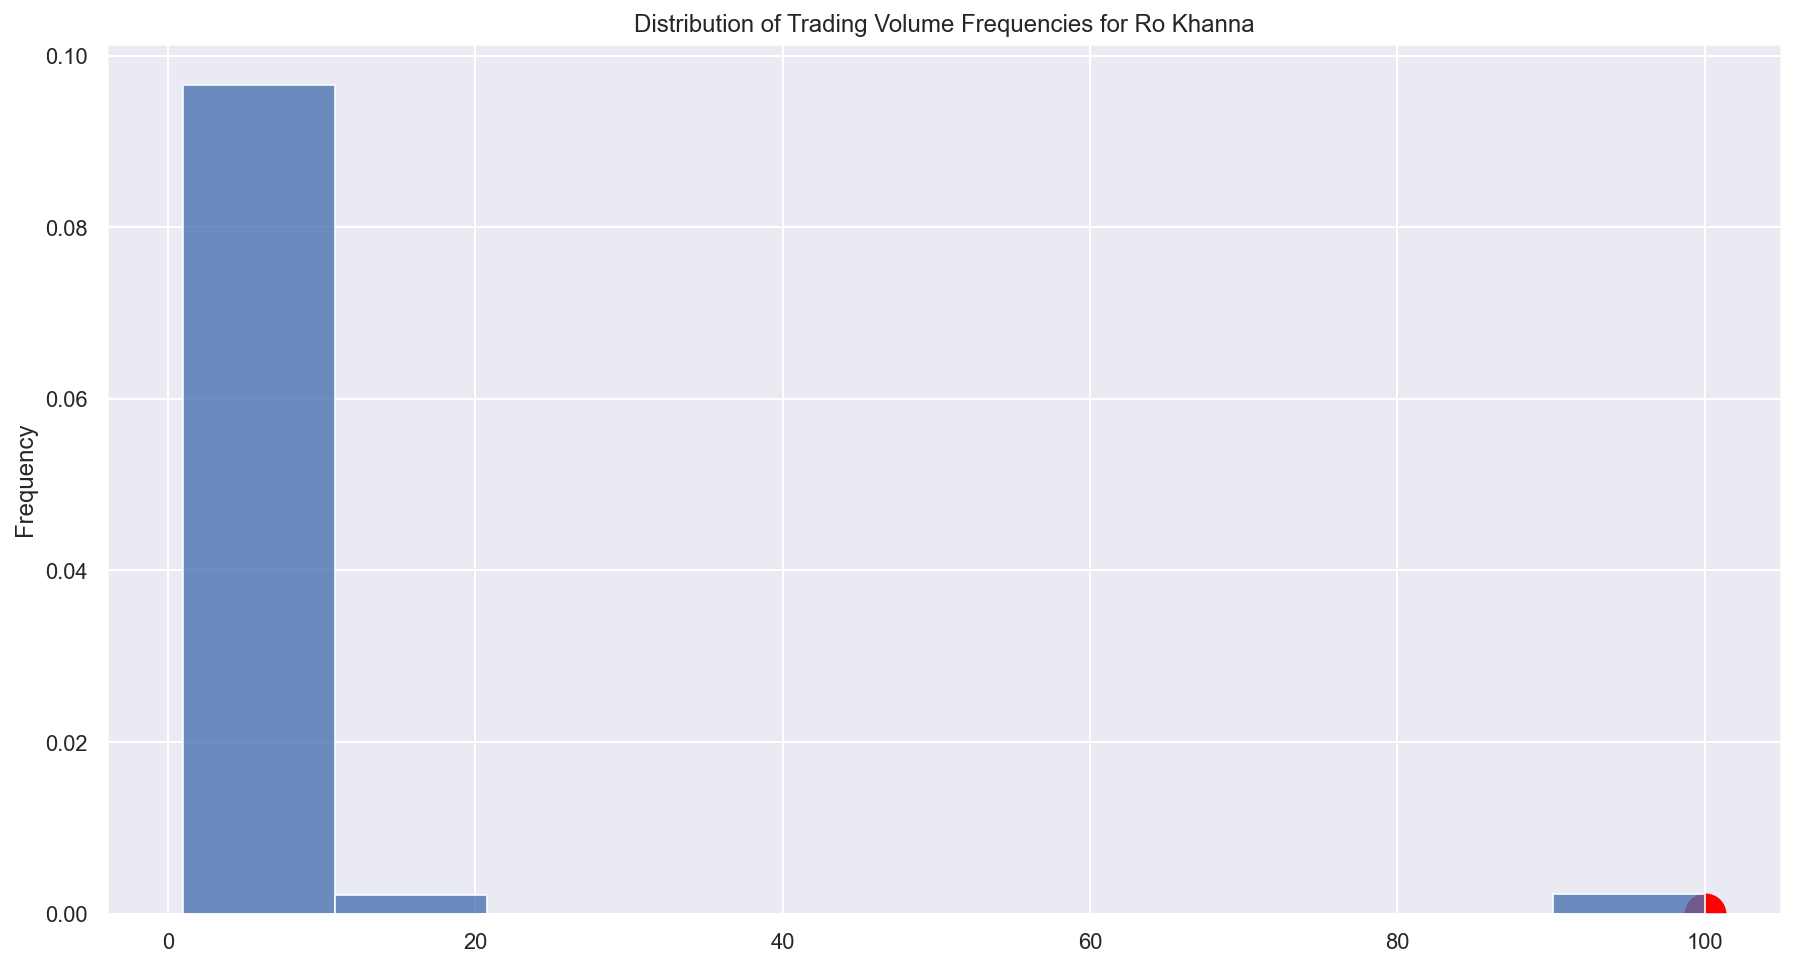

In [72]:
pd.Series(dists).plot(kind='hist', density=True, alpha=0.8, title="Distribution of Trading Volume Frequencies for Ro Khanna")
plt.scatter(obs, 0, color='red', s=400);

In [73]:
pval = (dists >= obs).mean()
pval

0.023

Our p-value exceeds our stated level of significance, so we cannot reject the null hypothesis and find insufficient support for the alternative hypothesis.